# Dependências e Setup

In [1]:
DEPENDENCIES_PATH = "requirements.txt"

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import os
import math
import zipfile

import pandas as pd
import numpy as np

from scipy.sparse import issparse
from scipy.sparse.linalg import eigsh
from numpy.linalg import eigvals, norm

import matplotlib.pyplot as plt

import torch, platform
import torch
import torch.nn as nn

from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import gradcheck

In [3]:
print("Torch:", torch.__version__, "| MPS:", torch.mps.is_available(), "| Py:", platform.python_version())

Torch: 2.9.1 | MPS: True | Py: 3.11.14


In [4]:
with zipfile.ZipFile("./content/states_with_bounds.npz", 'r') as zf:
    print("Conteúdo:", zf.namelist())

Conteúdo: ['n_in.npy', 'P.npy', 'C.npy', 'data.npy', 'Nu.npy', 'n_eq.npy', 'q.npy', 'Nx.npy', 'n_con.npy', 'Nh.npy', 'u_hover.npy', 'U.npy']


In [5]:
DATA_PATH = './content/states_with_bounds.npz'
SEED      = 42

# Funções Utilitárias

In [6]:
def set_seed():
    random.seed(SEED); np.random.seed(SEED)
    torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setup

In [166]:
set_seed()

# Pré-processamento e Dataset

## Carregamento do Dataset

Carregando dados que definem o problema de otimização a ser resolvidos a partir do arquivo .npz de input. Pequenos checks de dimensões e de condições da matriz P são realizados.

In [54]:
class MPC_Problem:

    def __init__(self, np_raw_path):

      raw = np.load(DATA_PATH)

      # Dimensions
      self.n_states = int(raw["Nx"])
      self.n_actuations = int(raw["Nu"])
      self.n_horizon = int(raw["Nh"])
      self.dim_z = (self.n_states + self.n_actuations) * self.n_horizon

      # Constraints
      self.n_constraints =  int(raw["n_con"])
      self.n_eq_constraints = int(raw["n_eq"])
      self.n_ineq_constraints = int(raw["n_in"])
      
      # Iterating through data to extract each instance:
      # -> Decision variables, Duals and Bounds

      self.input_data = raw["data"].astype(np.float32)
      it_pos = 0

      self.state_list = self.input_data[:, it_pos: it_pos + self.n_states]
      it_pos += self.n_states
      
      self.z_list = self.input_data[:, it_pos : it_pos + self.dim_z]
      it_pos += self.dim_z

      self.raw_dual = self.input_data[:, it_pos : it_pos + self.n_constraints]
      it_pos += self.n_constraints

      self.lower_bounds = self.input_data[:, it_pos : it_pos + self.n_constraints]
      it_pos += self.n_constraints

      self.upper_bounds = self.input_data[:, it_pos : it_pos + self.n_constraints]

      # Quadratic Programming Matrices
      self.P = raw["P"].astype(np.float64)
      self.q = raw["q"].astype(np.float64)
      self.C = raw["C"].astype(np.float64)
      self.U = raw["U"].astype(np.float64)

      # Constraints Matrix
      self.D = np.concatenate((self.C,  self.U), axis=0)

      # Duals Extraction
      self.lamb = np.maximum(-self.raw_dual, 0)
      self.nu = np.maximum(self.raw_dual, 0)

      # Dimension Check
      assert self.P.shape == (self.dim_z, self.dim_z), f"P must be [{self.dim_z},{self.dim_z}], got {self.P.shape}"
      assert self.q.shape == (self.dim_z,), f"q must be [{self.dim_z}], got {self.q.shape}"
      assert self.C.shape == (self.n_eq_constraints, self.dim_z), f"C must be [{self.n_eq_constraints},{self.dim_z}], got {self.Q.shape}"
      assert self.U.shape == (self.n_ineq_constraints, self.dim_z), f"U must be [{self.n_ineq_constraints},{self.dim_z}], got {self.U.shape}"

      N_samples = self.input_data.shape[0]
      assert self.state_list.shape[0] == N_samples, f"state_list must have {N_samples} samples, got {self.state_list.shape[0]}"
      assert self.z_list.shape[0] == N_samples, f"z_list must have {N_samples} samples, got {self.z_list.shape[0]}"
      assert self.raw_dual.shape[0] == N_samples, f"raw_dual must have {N_samples} samples, got {self.raw_dual.shape[0]}"
      assert self.upper_bounds.shape[0] == N_samples, f"upper_bounds must have {N_samples} samples, got {self.upper_bounds.shape[0]}"
      assert self.lower_bounds.shape[0] == N_samples, f"lower_bounds must have {N_samples} samples, got {self.lower_bounds.shape[0]}"
      
      assert self.state_list.shape[1] == self.n_states, f"state_list must have {self.n_states} features, got {self.state_list.shape[1]}"
      assert self.z_list.shape[1] == self.dim_z, f"z_list must have {self.dim_z} features, got {self.z_list.shape[1]}"
      assert self.raw_dual.shape[1] == self.n_constraints, f"raw_lag must have {self.n_constraints} features, got {self.raw_lag.shape[1]}"
      assert self.upper_bounds.shape[1] == self.n_constraints, f"upper_bounds must have {self.n_constraints} features, got {self.upper_bounds.shape[1]}"
      assert self.lower_bounds.shape[1] == self.n_constraints, f"lower_bounds must have {self.n_constraints} features, got {self.lower_bounds.shape[1]}"

      total_expected_cols = self.n_states + self.dim_z  + self.n_constraints * 3
      assert self.input_data.shape[1] == total_expected_cols, f"Total input columns must be {total_expected_cols}, got {self.input_data.shape[1]}. Check slicing logic."
      print(f"[CHECK] - Dimensions and Sampling Ok")

      # P nature checking
      eigvals = np.linalg.eigvalsh(self.P)
      assert np.all(eigvals >= -1e-8), f"P not positive semidefinite, min eig = {eigvals.min()}"
      print(f"[CHECK] - P Matrices are Positive Semidefinite")

    def check_P_matrix_condition(self):
      """
      The condition number gives an indication of the tightness
      of the bounds on the curvature of f, and therefore
      of the difficulty to optimize it: the bigger the value of
      κ is, the slowest is the convergence of the algorithm
      """
      condition_number = np.linalg.cond(self.P)
      print(f"[CHECK] - Condition Number of P: {condition_number}")
      if condition_number > 1e6:
        print(f"[WARNING] - Condition Number of P matrix is too high, this may lead to numerical instability")

    def apply_pre_processing(self):

      # Condition transformations
      self.apply_tikhonov_regularization()
      # self.normalizating_qp_matrices()

      # Distribuition transformation
      self.apply_state_standarization()
      self.apply_decision_variable_standarization()
      self.apply_duals_scalling()
      self.decision_variable_scalling()

    def apply_state_standarization(self):
      """
      x' = (x - x_mean) / x_std
      """
      self.state_mean = self.state_list.mean(axis=0)
      self.state_std = self.state_list.std(axis=0)
      self.state_list = (self.state_list - self.state_mean) / self.state_std
      print(f"[INFO] - State Standarization applied")

    def apply_decision_variable_standarization(self):
      """
      z' = (z - z_mean) / z_std
      """

      self.z_mean = self.z_list.mean(axis=0)
      self.z_std = self.z_list.std(axis=0)
      self.z_list = (self.z_list - self.z_mean) / self.z_std

      # This process must be applied to the constraints ineq:
      # a <= D z' <= b -> a <= D(mean) + (D @ diag(std)) z <= b
      # a' = a - D(mean) (same for b)
      # D' = D @ diag(std)

      self.lower_bounds = self.lower_bounds - self.D @ self.z_mean # Old D
      self.upper_bounds = self.upper_bounds - self.D @ self.z_mean # Old D
      self.D = self.D @ np.diag(self.z_std)
      
      # This process must be applie to the objective function:
      # P' = diag(std) @ P @ diag(std)
      # q = diag(std) @ P @ mean + diag(std) @ q

      self.q = np.diag(self.z_std) @ (self.P @ self.z_mean + self.q) # Dld P
      self.P = np.diag(self.z_std) @ self.P @ np.diag(self.z_std)

      print(f"[INFO] - Decision Variable Standarization applied")

    def apply_duals_scalling(self):
      """
      nu_std = (nu - nu_mean) / nu_std
      lambda_std = (lambda - lambda_mean) / lambda_std
      """
      self.nu = self.nu / (self.nu.std(axis=0) + 1e-6)
      self.lamb = self.lamb / (self.lamb.std(axis=0) + 1e-6)
      print(f"[INFO] - Duals Scalling by Std Dev applied")

    def apply_tikhonov_regularization(self, gamma=1e-6):
      """
      P_reg = P + gamma * I.
      Ensure positive definite and positive semidefinite nature of P and improve
      numerical stability by decreasing P condition number.
      """
      # Adicionar o termo de regularização à matriz P
      self.P = self.P + gamma * np.eye(self.P.shape[0], dtype=np.float64)
      print(f"[INFO] - Tikhonov Regularization applied = {gamma}")

    def normalizating_qp_matrices(self):
      """
        -> Normalizing P by its spectral norm
      """
      spec_norm_P = np.linalg.norm(self.P, ord=2)

      self.P = self.P / spec_norm_P
      self.q = self.q / spec_norm_P
      
      print(f"[INFO] - Normalizing P and q by P's spectral norm = {spec_norm_P}")

    def decision_variable_scalling(self):
      """
      Maps the optimization problem from z -> z', where
      z' = D^-1 z and D is calculated in order to reduce
      the condition number of P.

      D (or D^-1) must be applied to all the operations
      in relation to z
      """

      # Calculating scale:
      P_diag = np.diag(self.P)
      scale = np.sqrt(P_diag)
      scale[scale < 1e-9] = 1.0

      # Applying scale:
      self.z_scalling = np.diag(1.0 / scale)
      self.z_inv_scalling = np.diag(1.0 / np.diag(self.z_scalling))

      self.P = self.z_scalling.T @ self.P @ self.z_scalling
      self.q = self.z_scalling.T @ self.q
      self.D = self.D @ self.z_scalling

      self.z_list = self.z_list @ self.z_scalling 

      print(f"[INFO] - Decision Variable Scaling applied")

    def visualize_bounds(self):
      x = self.lower_bounds
      z = self.upper_bounds

      plt.figure(figsize=(10, 4))
      plt.boxplot(x, showfliers=False)
      plt.title("Lower Bounds (z_inf)")
      plt.xlabel("Dimension")
      plt.ylabel("Value")
      plt.grid(True)
      plt.show()

      plt.figure(figsize=(10, 4))
      plt.boxplot(z, showfliers=False)
      plt.title("Upper Bounds (z_sup)")
      plt.xlabel("Dimension")
      plt.ylabel("Value")
      plt.grid(True)
      plt.show()

    def visualize_duals(self):

        plt.figure(figsize=(10, 4))
        plt.boxplot(self.lamb, showfliers=False)
        plt.title("Lambda (lower bound dual)")
        plt.xlabel("Dimension")
        plt.ylabel("Value")
        plt.grid(True)
        plt.show()

        lamb_mean = self.lamb.mean(axis=0)

        plt.figure(figsize=(10, 4))
        plt.bar(range(len(lamb_mean)), lamb_mean, capsize=5)
        plt.title("Lambda – Mean value per dimension")
        plt.xlabel("Dimension")
        plt.ylabel("Mean")
        plt.grid(True, axis='y')
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.boxplot(self.nu, showfliers=False)
        plt.title("Nu (upper bound dual)")
        plt.xlabel("Dimension")
        plt.ylabel("Value")
        plt.grid(True)
        plt.show()

        nu_mean = self.nu.mean(axis=0)

        plt.figure(figsize=(10, 4))
        plt.bar(range(len(nu_mean)), nu_mean, capsize=5)
        plt.title("Nu – Mean value per dimension")
        plt.xlabel("Dimension")
        plt.ylabel("Mean")
        plt.grid(True, axis='y')
        plt.show()


    def visualize_decision_vars(self):
      x = self.state_list
      z = self.z_list

      def summarize_array(arr, name):
        df = pd.DataFrame(arr, columns=[f"{name}_{i}" for i in range(arr.shape[1])])
        desc = df.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
        print(f"\nResumo estatístico de {name}:")
        print(desc[["mean", "std", "min", "1%", "5%", "50%", "95%", "99%", "max"]])
        return desc

      summarize_array(x, "x")
      summarize_array(z, "z")

      plt.figure(figsize=(10, 4))
      plt.boxplot(x, showfliers=False)
      plt.title("State Distribuition (x)")
      plt.xlabel("Dimension")
      plt.ylabel("Value")
      plt.grid(True)
      plt.show()

      plt.figure(figsize=(10, 4))
      plt.boxplot(z, showfliers=False)
      plt.title("Decision Variable Distribuition (z)")
      plt.xlabel("Dimension")
      plt.ylabel("Value")
      plt.grid(True)
      plt.show()

    def visualize_C_and_U(self):

      def _visualize_matrix(M, title_prefix="Matrix"):
        diag = np.diag(M)

        fig, axs = plt.subplots(1, 3, figsize=(16, 4))

        # 1. Valores da diagonal
        axs[0].plot(diag, marker='o')
        axs[0].set_title(f"{title_prefix} – diagonal")
        axs[0].set_xlabel("Index")
        axs[0].set_ylabel("Value")

        # 2. Heatmap da matriz
        im = axs[1].imshow(M, aspect='auto', cmap='viridis')
        axs[1].set_title(f"{title_prefix} – heatmap")
        plt.colorbar(im, ax=axs[1])

        # 3. Heatmap absoluto (concentração de valores)
        im2 = axs[2].imshow(np.abs(M), aspect='auto', cmap='inferno')
        axs[2].set_title(f"{title_prefix} – magnitude |M|")
        plt.colorbar(im2, ax=axs[2])

        plt.tight_layout()
        plt.show()

      print("=== C MATRIX ===")
      _visualize_matrix(self.C, title_prefix="C")

      print("=== U MATRIX ===")
      _visualize_matrix(self.U, title_prefix="U")

      print("=== D MATRIX ===")
      _visualize_matrix(self.D, title_prefix="D")

    def visualize_P_and_q(self):

      P = self.P
      q = self.q
      P = P if not issparse(P) else P.tocsr()
      q = q.reshape(-1)

      # ---- 1. SPY Plot ----
      plt.figure(figsize=(6, 6))
      if issparse(P):
        plt.spy(P, markersize=1)
      else:
        plt.imshow(P != 0, aspect="auto", cmap="gray_r")
      plt.title("Sparsity Pattern of P")
      plt.show()

      # ---- 2. Heatmap for dense or sampled ----
      if not issparse(P) and P.shape[0] <= 3000:
        plt.figure(figsize=(6, 5))
        plt.imshow(P, aspect='auto')
        plt.title("Heatmap of P values")
        plt.colorbar()
        plt.show()

      # ---- 3. Histogram of values ----
      P_vals = P.data if issparse(P) else P.flatten()
      plt.figure(figsize=(6,4))
      plt.hist(P_vals, bins=100)
      plt.title("Distribution of P entries")
      plt.show()

      plt.figure(figsize=(6,4))
      plt.hist(q, bins=50)
      plt.title("Distribution of q entries")
      plt.show()

      # ---- Boxplot & Violinplot for q ----
      plt.figure(figsize=(6,4))
      plt.boxplot(q)
      plt.title("Boxplot of q values")
      plt.show()

      plt.figure(figsize=(6,4))
      plt.violinplot(q, showmeans=True)
      plt.title("Violin Plot of q values")
      plt.show()

      # ---- 4. Symmetry check ----
      if not issparse(P):
        sym_error = norm(P - P.T)
        print(f"Symmetry error ||P - P^T||: {sym_error}")

      # ---- 5. Eigenvalues (smallest few) ----
      print("Estimating smallest eigenvalues of P...")
      try:
        if issparse(P):
          evals = eigsh(P, k=6, which='SA')[0]
        else:
          evals = np.sort(eigvals(P).real)[:6]
        print("Smallest eigenvalues:", evals)

        plt.figure(figsize=(6,4))
        plt.hist(evals, bins=10)
        plt.title("Histogram of smallest eigenvalues of P")
        plt.show()

        # ---- Boxplot & Violinplot for eigenvalues ----
        plt.figure(figsize=(6,4))
        plt.boxplot(evals)
        plt.title("Boxplot of smallest eigenvalues of P")
        plt.show()


        plt.figure(figsize=(6,4))
        plt.violinplot(evals, showmeans=True)
        plt.title("Violin Plot of smallest eigenvalues of P")
        plt.show()
        plt.title("Histogram of smallest eigenvalues of P")
        plt.show()

      except Exception as e:
        print("Eigenvalue analysis failed:", e)

      # ---- 6. Row norm profile ----
      if not issparse(P):
        row_norms = np.linalg.norm(P, axis=1)
      else:
        row_norms = np.sqrt(P.multiply(P).sum(axis=1)).A.flatten()


      plt.figure(figsize=(8,4))
      plt.plot(row_norms)
      plt.title("Row Norm Profile of P")
      plt.show()

      # ---- 7. Inspect q structure ----
      plt.figure(figsize=(8,4))
      plt.plot(q)
      plt.title("q vector profile")
      plt.show()


In [49]:
MPC = MPC_Problem(DATA_PATH)

[CHECK] - Dimensions and Sampling Ok
[CHECK] - P Matrices are Positive Semidefinite


## Visualização


Resumo estatístico de x:
          mean         std           min         1%        5%       50%  \
x_0   0.013745    5.773324    -10.000000  -9.800100 -9.030000  0.090000   
x_1   0.003348    5.769179    -10.000000  -9.810000 -9.020000  0.040000   
x_2   5.065572    2.907116      0.000000   0.090000  0.510000  5.070000   
x_3  -0.011804  331.808319 -32117.119141 -34.080762 -6.329666  0.013071   
x_4  -1.710566  275.892426 -22785.537109 -35.481147 -6.412554 -0.004827   
x_5   1.860883  338.268494 -12496.941406 -30.426435 -6.218714  0.007816   
x_6   0.042395    2.889105     -5.000000  -4.900000 -4.480000  0.060000   
x_7   0.042685    2.907703     -5.000000  -4.910000 -4.480000  0.060000   
x_8   0.016282    2.903462     -5.000000  -4.920000 -4.540000  0.030000   
x_9  -0.000019    2.895735     -5.000000  -4.910000 -4.510000  0.000000   
x_10  0.021732    2.888635     -5.000000  -4.910000 -4.500000  0.010000   
x_11 -0.005353    2.883911     -5.000000  -4.910000 -4.500000 -0.030000   

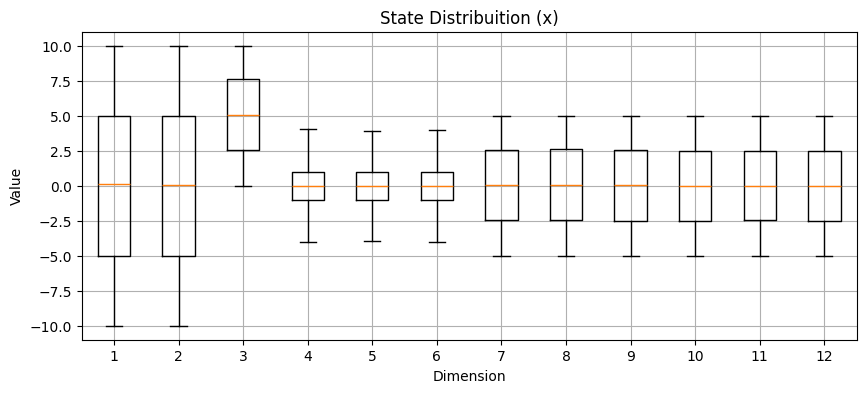

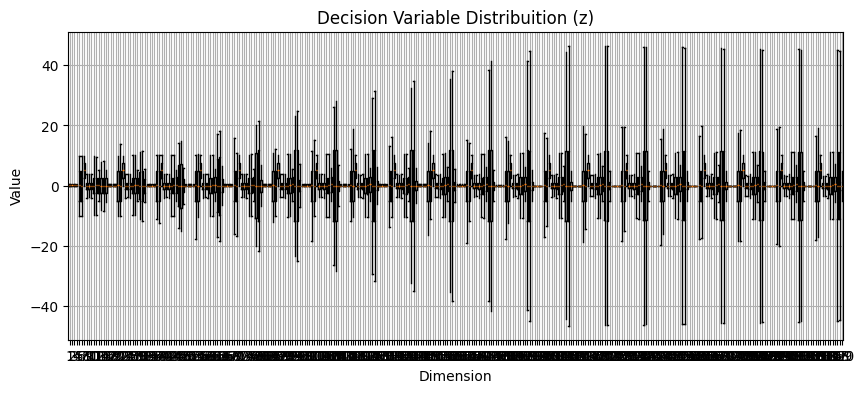

In [17]:
MPC.visualize_decision_vars()

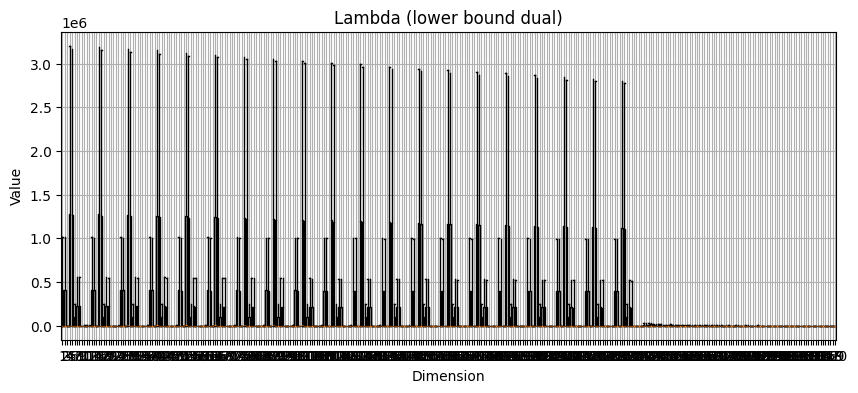

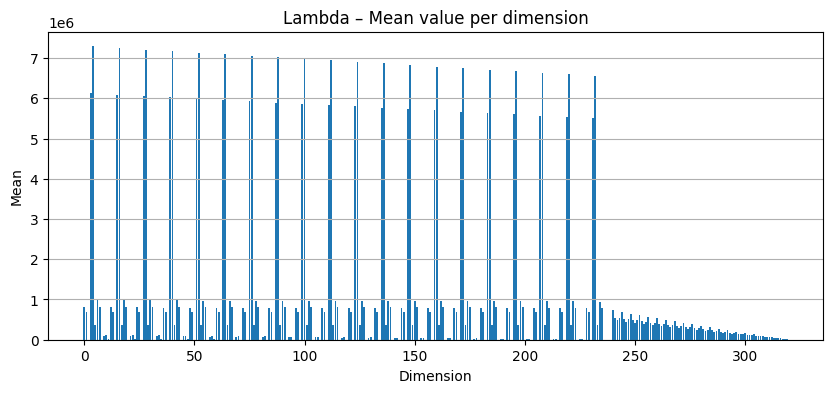

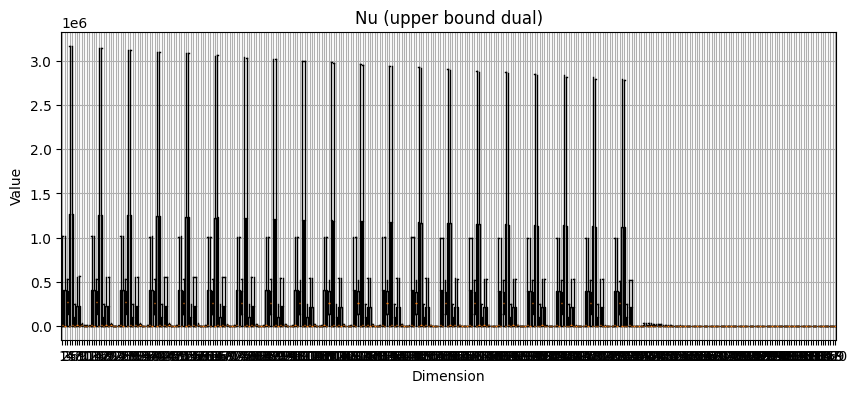

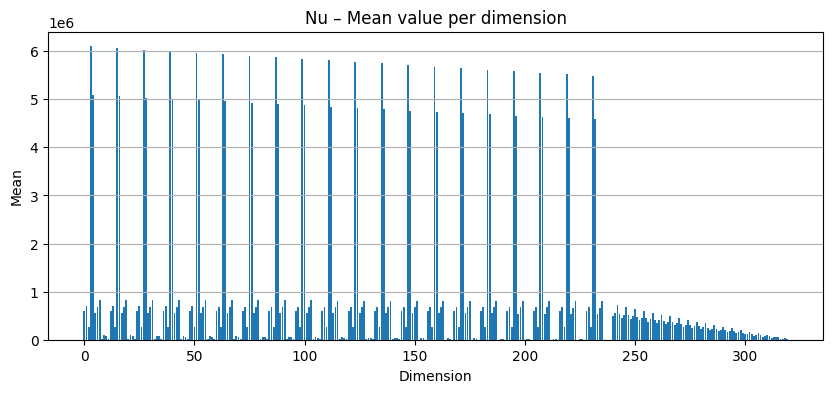

In [10]:
MPC.visualize_duals()

In [ ]:
MPC.visualize_bounds()

In [ ]:
MPC.visualize_P_and_q()

In [ ]:
MPC.visualize_C_and_U()

## Melhorando a condicionalidade do problema

In [55]:
MPC.check_P_matrix_condition()

[CHECK] - Condition Number of P: 9.781309233854252


In [56]:
MPC.apply_pre_processing()

[INFO] - Tikhonov Regularization applied = 1e-06
[INFO] - State Standarization applied
[INFO] - Decision Variable Standarization applied
[INFO] - Duals Scalling by Std Dev applied
[INFO] - Decision Variable Scaling applied


In [57]:
MPC.check_P_matrix_condition()

[CHECK] - Condition Number of P: 9.781268849225063



Resumo estatístico de x:
              mean       std        min        1%        5%       50%  \
x_0   9.918213e-09  1.000025  -1.734529 -1.699903 -1.566510  0.013208   
x_1  -5.722046e-09  1.000025  -1.733973 -1.701038 -1.564100  0.006353   
x_2  -1.182556e-08  1.000025  -1.742517 -1.711558 -1.567081  0.001523   
x_3   0.000000e+00  1.000025 -96.796585 -0.102679 -0.019041  0.000075   
x_4   1.907349e-10  1.000025 -82.584351 -0.122408 -0.017043  0.006183   
x_5  -1.907349e-10  1.000025 -36.950283 -0.095451 -0.023886 -0.005478   
x_6  -1.344681e-08  1.000025  -1.745358 -1.710744 -1.565367  0.006094   
x_7  -4.196167e-09  1.000025  -1.734294 -1.703341 -1.555454  0.005955   
x_8  -9.155274e-09  1.000025  -1.727733 -1.700179 -1.569298  0.004725   
x_9   8.201599e-09  1.000025  -1.726714 -1.695633 -1.557495  0.000007   
x_10  1.907349e-09  1.000025  -1.738488 -1.707330 -1.565391 -0.004062   
x_11 -1.296997e-08  1.000025  -1.731943 -1.700735 -1.558564 -0.008546   

           95%       99%

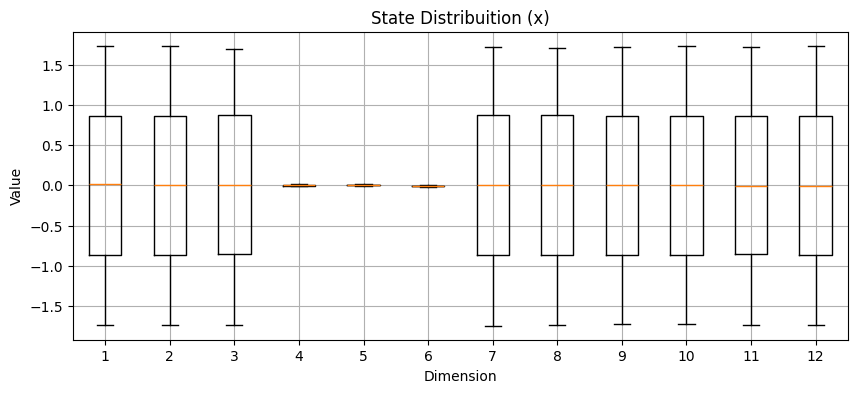

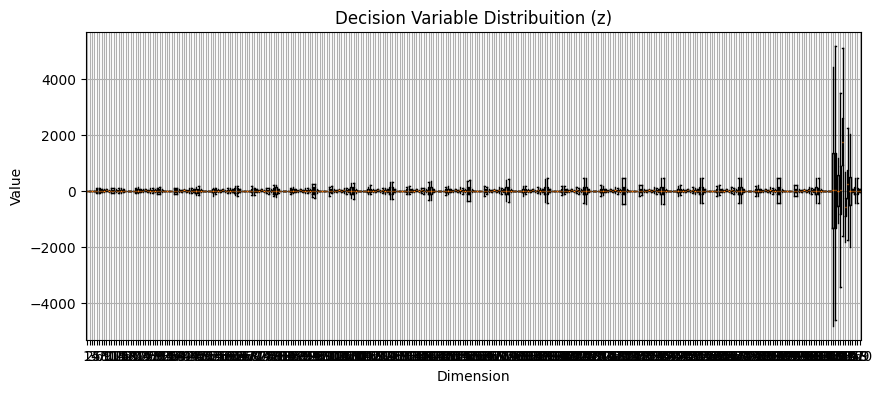

In [58]:
MPC.visualize_decision_vars()

In [ ]:
MPC.visualize_duals()

In [ ]:
MPC.visualize_bounds()

In [ ]:
MPC.visualize_P_and_q()

## Definindo DataClass do Pytorch

In [187]:
class MPC_DATASET(Dataset):

  def __init__(self, MPC):

    self.states = MPC.state_list
    self.decision_variables = MPC.z_list
    self.nu_lagrangians = MPC.nu
    self.lambda_lagrangians = MPC.lamb
    self.lower_bounds = MPC.lower_bounds
    self.upper_bounds = MPC.upper_bounds

    # Pre-processed QP Matrices
    self.P_scaled = torch.from_numpy(MPC.P).float()
    self.q_scaled = torch.from_numpy(MPC.q).float()
    self.D_scaled = torch.from_numpy(MPC.D).float()

    # Pre-processing parameters
    self.state_mean = MPC.state_mean
    self.state_std = MPC.state_std
    self.z_mean = MPC.z_mean
    self.z_std = MPC.z_std
    self.z_scalling = MPC.z_scalling
    self.z_inv_scalling = MPC.z_inv_scalling

    # print(f"[CHECK] States list dimension: {self.states.shape}")
    # print(f"[CHECK] Decision Variables lis dimension: {self.decision_variables.shape}")
    # print(f"[CHECK] Nu Lagrangians dimension: {self.nu_lagrangians.shape}")
    # print(f"[CHECK] Lambda Lagrangians dimension: {self.lambda_lagrangians.shape}")

    # print(f"[CHECK] States list element list[i]: {self.states[0].shape}")
    # print(f"[CHECK] Decision Variables list element list[i]: {self.decision_variables[0].shape}")
    # print(f"[CHECK] Nu Lagrangians element list[i]: {self.nu_lagrangians[0].shape}")
    # print(f"[CHECK] Lambda Lagrangians element list[i]: {self.lambda_lagrangians[0].shape}")

    # print(f"[CHECK] State element when applied torch.from_numpy(x_std).float(),: {torch.from_numpy(self.states[0]).float().shape}")
    # print(f"[CHECK] Decision Variable element when applied torch.from_numpy(z_scaled).float(),: {torch.from_numpy(self.decision_variables[0]).float().shape}")


  def __len__(self):
    return self.states.shape[0]

  def __getitem__(self, i):

    """
    Returning:
    -> x with standarization
    -> z' with scaling (z' = D^-1 z)
    -> nu with strandarization
    -> lambda with strandarization
    -> z_inf
    -> z_sup
    """
    x_std = self.states[i]
    z_scaled = self.decision_variables[i]
    nu = self.nu_lagrangians[i]
    lam = self.lambda_lagrangians[i]
    lb = self.lower_bounds[i]
    ub = self.upper_bounds[i]

    return {
        "x": torch.from_numpy(x_std).float(),
        "z": torch.from_numpy(z_scaled).float(),
        "nu": torch.from_numpy(nu).float(),
        "lam": torch.from_numpy(lam).float(),
        "lb": torch.from_numpy(lb).float(),
        "ub": torch.from_numpy(ub).float()
    }

In [188]:
DATASET = MPC_DATASET(MPC)

# Função de Loss Lagrangiana

Criação de um módulo customizado de Loss Function do PyTorch para ser capaz de otimizar a rede utilizando a informação dos multiplicadores de lagrande para realizar um aprendizado que respeite a natureza restringida do problema de otimização no politopo.

$$
\ell(\theta) :=
\sum_{i=1}^{}
\Big(
    ℒ\big(\tilde{\pi}(x_i \mid \theta), \nu_i^{\ast}, \lambda_i^{\ast} \mid x_i\big)
    - ℒ\big(z_i^{\ast}, \nu_i^{\ast}, \lambda_i^{\ast} \mid x_i\big)
\Big)^2
$$

### Cálculo do Lagrangiano
Feito a partir da interpretação das matrizes C e U como matrizes das restrições de igualdade e desigualdade em zero.

$$
ℒ(z, \nu, \lambda) = \frac{1}{2}z^t\mathbf{P}z + \mathbf{q}^Tz + \lambda(\mathbf{D}z - z_{inf}) + \nu^t(z_{sup} - \mathbf{D}z) 
$$


In [97]:
class LagrangianLoss(nn.Module):
    def __init__(self, P, q, D):
        """
        P: (n,n) tensor
        q: (n,) or (n,1) tensor
        D: (m,n) tensor
        """
        super().__init__()

        if q.dim() == 1:
            q = q.unsqueeze(-1)  # (n,1)

        # store as float buffers (detached)
        self.register_buffer("P", P.clone().detach().float())
        self.register_buffer("q", q.clone().detach().float())  # (n,1)
        self.register_buffer("D", D.clone().detach().float())  # (m,n)

    def _ensure_batch_shape_bound(self, bound, B):
        """Make bound shape (B, m) from either (m,) or (B,m)."""
        if bound is None:
            return None
        if bound.dim() == 1:
            return bound.unsqueeze(0).expand(B, -1)  # (B, m)
        elif bound.dim() == 2:
            return bound
        else:
            raise ValueError("Bounds must be shape (m,) or (B,m).")

    def lagrangian(self, z, nu, lam, lower_bound=None, upper_bound=None):
        """
        z: (B, n)
        nu: (B, m)  -- multipliers for upper bounds (u - Dz)
        lam: (B, m) -- multipliers for lower bounds (Dz - l)
        lower_bound: (m,) or (B, m)  (l)
        upper_bound: (m,) or (B, m)  (u)

        Returns: L (B,)  (per-sample Lagrangian value)
        """
        # get dtype-correct buffers
        dtype = z.dtype
        P = self.P.to(dtype)      # (n,n)
        q = self.q.to(dtype).squeeze(-1)  # (n,)
        D = self.D.to(dtype)      # (m,n)

        B = z.shape[0]
        lb = self._ensure_batch_shape_bound(lower_bound, B)  # (B,m)
        ub = self._ensure_batch_shape_bound(upper_bound, B)  # (B,m)

        # ---- Quadratic term: 0.5 * z^T P z  ----
        # z @ P -> (B,n); elementwise * z -> (B,n); sum -> (B,)
        zP = torch.matmul(z, P)              # (B, n)
        quadratic = 0.5 * torch.sum(zP * z, dim=1)  # (B,)

        # ---- Linear term: q^T z ----
        linear = torch.sum(q * z, dim=1)     # (B,)

        # ---- D z (constraints) ----
        Dz = torch.matmul(z, D.t())          # (B, m)

        # ---- Lower bound term: lam^T (Dz - lb) ----
       
        lower = torch.sum(lam * (Dz - lb), dim=1)

        # ---- Upper bound term: nu^T (ub - Dz) ----
        upper = torch.sum(nu * (ub - Dz), dim=1)

        total = quadratic + linear + lower + upper  # (B,)
        return total

    def lagrangian_components(self, z, nu, lam, lower_bound=None, upper_bound=None):
        """
        Returns per-term components (each shape (B,)):
          (quadratic, linear, lower_term, upper_term)
        """
        dtype = z.dtype
        P = self.P.to(dtype)
        q = self.q.to(dtype).squeeze(-1)
        D = self.D.to(dtype)

        B = z.shape[0]
        lb = self._ensure_batch_shape_bound(lower_bound, B)
        ub = self._ensure_batch_shape_bound(upper_bound, B)

        zP = torch.matmul(z, P)              # (B, n)
        quadratic = 0.5 * torch.sum(zP * z, dim=1)  # (B,)

        linear = torch.sum(q * z, dim=1)     # (B,)

        Dz = torch.matmul(z, D.t())          # (B, m)

        if lb is None:
            lower = torch.sum(lam * Dz, dim=1)
        else:
            lower = torch.sum(lam * (Dz - lb), dim=1)

        if ub is None:
            upper = torch.sum(nu * (-Dz), dim=1)
        else:
            upper = torch.sum(nu * (ub - Dz), dim=1)

        return quadratic, linear, lower, upper

    def forward_components(self, z_pred, z_opt, nu, lam, lower_bound=None, upper_bound=None):
        """
        Compute mean differences of components (per original example):
          d_quad = mean(quad_pred - quad_opt)   (scalar)
          d_lin  = mean(...)
          d_eq   = mean(lower_pred - lower_opt)
          d_ineq = mean(upper_pred - upper_opt)
        """
        quad_pred, lin_pred, lower_pred, upper_pred = self.lagrangian_components(
            z_pred, nu, lam, lower_bound, upper_bound
        )
        quad_opt, lin_opt, lower_opt, upper_opt = self.lagrangian_components(
            z_opt, nu, lam, lower_bound, upper_bound
        )

        d_quad = (quad_pred - quad_opt).mean()
        d_lin  = (lin_pred  - lin_opt ).mean()
        d_eq   = (lower_pred - lower_opt).mean()
        d_ineq = (upper_pred - upper_opt).mean()

        return d_quad, d_lin, d_eq, d_ineq

    def forward(self, z_pred, z_opt, nu, lam, lower_bound=None, upper_bound=None):
        """
        Default loss: mean((L_pred - L_opt)^2)
        All inputs are batch-shaped.
        """
        L_pred = self.lagrangian(z_pred, nu, lam, lower_bound, upper_bound)
        L_opt  = self.lagrangian(z_opt,  nu, lam, lower_bound, upper_bound)
        loss = ((L_pred - L_opt) ** 2).mean()
        return loss


In [189]:
class AugmentedLagrangianLoss(nn.Module):
    def __init__(self, P, q, D, rho):
        super().__init__()

        if q.dim() == 1:
            q = q.unsqueeze(-1)  # (n,1)

        self.register_buffer("P", P.clone().detach().float())   # (n,n)
        self.register_buffer("q", q.clone().detach().float())   # (n,1)
        self.register_buffer("D", D.clone().detach().float())   # (m,n)
        self.rho = float(rho)

    def _ensure_batch_bound(self, b, B):
        """Ensure bound is (B,m)."""
        if b is None:
            return None
        if b.dim() == 1:
            return b.unsqueeze(0).expand(B, -1)
        elif b.dim() == 2:
            return b
        else:
            raise ValueError("bound must be (m,) or (B,m).")

    def augmented_lagrangian(self, z, lam_inf, lam_sup, lower_bound, upper_bound):
        """
        z:        (B,n)
        lam_inf:  (B,m)
        lam_sup:  (B,m)
        lower_bound: (m,) or (B,m)
        upper_bound: (m,) or (B,m)

        output: (B,) augmented Lagrangian value
        """
        dtype = z.dtype
        P = self.P.to(dtype)
        q = self.q.to(dtype).squeeze(-1)   # (n,)
        D = self.D.to(dtype)

        B = z.shape[0]
        lb = self._ensure_batch_bound(lower_bound, B)  # (B,m)
        ub = self._ensure_batch_bound(upper_bound, B)  # (B,m)

        # ---------------------------------------------------------
        # QUADRATIC: 0.5 zᵀ P z
        # ---------------------------------------------------------
        zP = torch.matmul(z, P)                   # (B,n)
        quad = 0.5 * torch.sum(zP * z, dim=1)     # (B,)

        # ---------------------------------------------------------
        # LINEAR: qᵀ z
        # ---------------------------------------------------------
        lin = torch.sum(q * z, dim=1)             # (B,)

        # ---------------------------------------------------------
        # D z
        # ---------------------------------------------------------
        Dz = torch.matmul(z, D.t())               # (B,m)

        # ---------------------------------------------------------
        # Lagrangian linear terms
        # λ_infᵀ (l - Dz)
        # λ_supᵀ (Dz - u)
        # ---------------------------------------------------------
        lag_inf = torch.sum(lam_inf * (lb - Dz), dim=1)
        lag_sup = torch.sum(lam_sup * (Dz - ub), dim=1)

        # ---------------------------------------------------------
        # Augmented terms: ρ/2 ||max(0, l - Dz)||²
        #                  ρ/2 ||max(0, Dz - u)||²
        # ---------------------------------------------------------
        viol_inf = torch.relu(lb - Dz)            # (B,m)
        viol_sup = torch.relu(Dz - ub)            # (B,m)

        aug_inf = 0.5 * self.rho * torch.sum(viol_inf ** 2, dim=1)
        aug_sup = 0.5 * self.rho * torch.sum(viol_sup ** 2, dim=1)

        return quad + lin + lag_inf + lag_sup + aug_inf + aug_sup

    def forward(self, z_pred, z_opt, lam_inf, lam_sup, lower_bound, upper_bound):
        """
        Loss = mean( (L_aug(z_pred) - L_aug(z_opt))² )
        """
        L_pred = self.augmented_lagrangian(z_pred, lam_inf, lam_sup,
                                           lower_bound, upper_bound)
        L_opt = self.augmented_lagrangian(z_opt, lam_inf, lam_sup,
                                          lower_bound, upper_bound)
        return ((L_pred - L_opt) ** 2).mean()

In [ ]:
# # USAR A DE BAIXO, QUE ESTÁ VETORIZADA
# class LagrangianLoss(nn.Module):
#     def __init__(self, P, q, D):
#         super().__init__()

#         if q.dim() == 1:
#             q = q.unsqueeze(-1)

#         P = P.clone().detach().to(torch.float)
#         q = q.clone().detach().to(torch.float)
#         D = D.clone().detach().to(torch.float)

#         self.register_buffer("P", P)
#         self.register_buffer("q", q)
#         self.register_buffer("D", D)

#     def lagrangian(self, z, nu, lam, lb, ub):
#         # print("DIMENSION VALIDATION IN LOSS")
#         # print(f"--> P: {P.shape}")
#         # print(f"--> q: {q.shape}")
#         # print(f"--> D: {D.shape}")
#         # print("--------------------------")
#         # print(f"--> z: {z.shape}")
#         # print(f"--> nu: {nu.shape}")
#         # print(f"--> lam: {lam.shape}")
#         # print("--------------------------\n")

#         z = z.unsqueeze(-1).float()
#         nu = nu.unsqueeze(-1).float()
#         lam = lam.unsqueeze(-1).float()
#         lb = lb.unsqueeze(-1).float()
#         ub = ub.unsqueeze(-1).float()

#         print("LAGRANGIA CALCULATION IN LOSS")

#         print(f"-> Quadratic term:")
#         print(f"---- P @ z: {(self.P @ z).shape}")
#         print(f"---- z.T: {z.T.shape}")
#         print(f"---- z.T @ (self.P @ z): {(z.T @ (self.P @ z)).shape}")
#         print("--------------------------\n")

#         print("-> Linear term:")
#         print(f"----- q.T: {self.q.T.shape}")
#         print(f"----- q.T @ z: {(self.q.T @ z).shape}")
#         print("--------------------------\n")

#         print("-> Lower Bound term:")
#         print(f"----- D @ z: {(self.D @ z).shape}")
#         print(f"----- lambda.T: {(lam.T).shape}")
#         print(f"-----> lam.T @ (self.D @ z - lb): {(lam.T @ (self.D @ z - lb)).shape}")
#         print("--------------------------\n")

#         print("-> Upper Bound term:")
#         print(f"----- D @ z: {(self.D @ z).shape}")
#         print(f"----- nu.T: {(nu.T).shape}")
#         print(f"-----> nu.T @ (ub - self.D @ z): {(nu.T @ (ub - self.D @ z)).shape}")
#         print("--------------------------\n")

#         quadratic_term = 0.5 * z.T @ (self.P @ z)
#         linear_term    = self.q.T @ z
#         lower_term     = lam.T @ (self.D @ z - lb)
#         upper_term      = nu.T @ (ub - self.D @ z)
#         return (quadratic_term + linear_term + lower_term + upper_term).squeeze()

#     def forward(self, z_pred, z_opt, nu_star, lam_star, lower_bound, upper_bound):

#       batch_losses = []
#       for i in range(z_pred.shape[0]):
#           L_pred = self.lagrangian(z_pred[i], nu_star[i], lam_star[i], lower_bound[i], upper_bound[i])
#           L_opt  = self.lagrangian(z_opt[i],  nu_star[i], lam_star[i], lower_bound[i], upper_bound[i])
#           loss_i = (L_pred - L_opt).pow(2)
#           batch_losses.append(loss_i)
#       return torch.stack(batch_losses).mean()


In [ ]:
# class LagrangianLoss(nn.Module):
#     def __init__(self, P, q, D):
#         super().__init__()

#         if q.dim() == 1:
#             q = q.unsqueeze(-1)

#         self.register_buffer("P", P.clone().detach().float())
#         self.register_buffer("q", q.clone().detach().float())
#         self.register_buffer("D", D.clone().detach().float())

#     def lagrangian(self, z, nu, lam):
#         dtype = z.dtype

#         # ---- Convert buffers to proper dtype ----
#         P = self.P.to(dtype)
#         q = self.q.to(dtype)
#         D = self.C.to(dtype)

#         # ---- Quadratic ----
#         zP = torch.matmul(z, P)  # [B, n]
#         quadratic = 0.5 * torch.sum(zP * z, dim=1)

#         # ---- Linear ----
#         linear = torch.sum(q.squeeze() * z, dim=1)

#         # ---- Lower Bound ----
#         Dz = torch.matmul(z, D.T)
#         eq_term = torch.sum(nu * Cz, dim=1)

#         # ---- Inequality ----
#         Uz = torch.matmul(z, U.T)
#         ineq_term = torch.sum(lam * Uz, dim=1)

#         # =====================================================
#         #                     DEBUG PRINTS
#         # =====================================================
#         # print("\n================ LAGRANGIAN DEBUG ================")
#         # print("Input z:\n", z)
#         # print("Multipliers nu:\n", nu)
#         # print("Multipliers λ:\n", lam)

#         # print("\n--- Contribution of each Lagrangian term ---")
#         # print("Quadratic = 0.5 * zᵀ P z:\n", quadratic)
#         # print("Linear = qᵀ z:\n", linear)
#         # print("Equality term = nuᵀ (Cz):\n", eq_term)
#         # print("Inequality term = lamᵀ (Uz):\n", ineq_term)

#         total = quadratic + linear + eq_term + ineq_term
#         # print("\nTOTAL LAGRANGIAN VALUE:\n", total)
#         # print("====================================================\n")

#         return total

#     def lagrangian_components(self, z, nu, lam):

#         dtype = z.dtype
#         # ---- Convert buffers to proper dtype ----
#         P = self.P.to(dtype)
#         q = self.q.to(dtype)
#         C = self.C.to(dtype)
#         U = self.U.to(dtype)

#         # ---- Quadratic ----
#         zP = torch.matmul(z, P)  # [B, n]
#         quadratic = 0.5 * torch.sum(zP * z, dim=1)

#         # ---- Linear ----
#         linear = torch.sum(q.squeeze() * z, dim=1)

#         # ---- Equality ----
#         Cz = torch.matmul(z, C.T)
#         eq_term = torch.sum(nu * Cz, dim=1)

#         # ---- Inequality ----
#         Uz = torch.matmul(z, U.T)
#         ineq_term = torch.sum(lam * Uz, dim=1)
#         return quadratic, linear, eq_term, ineq_term


#     def forward_components(self, z_pred, z_opt, nu, lam):

#       quad_pred, lin_pred, eq_pred, ineq_pred = self.lagrangian_components(z_pred, nu, lam)
#       quad_opt,  lin_opt,  eq_opt,  ineq_opt = self.lagrangian_components(z_opt,  nu, lam)

#       # Δ = pred − opt   (por amostra no batch)
#       d_quad = (quad_pred - quad_opt).mean()
#       d_lin  = (lin_pred  - lin_opt ).mean()
#       d_eq   = (eq_pred   - eq_opt  ).mean()
#       d_ineq = (ineq_pred - ineq_opt).mean()

#       return d_quad, d_lin, d_eq, d_ineq

#     def forward(self, z_pred, z_opt, nu, lam):
#         L_pred = self.lagrangian(z_pred, nu, lam)
#         L_opt  = self.lagrangian(z_opt,  nu, lam)

#         loss = ((L_pred - L_opt)**2).mean()

#         # print("\n*********** LOSS DEBUG ***********")
#         # print("L_pred:", L_pred)
#         # print("L_opt:",  L_opt)
#         # print("Loss = mean((L_pred - L_opt)^2):", loss)
#         # print("*********************************\n")

#         return loss


In [105]:
INIT_RHO = 1
LOSS = AugmentedLagrangianLoss(DATASET.P_scaled, DATASET.q_scaled, DATASET.D_scaled, INIT_RHO)

## Validação da Loss

### Avaliação com dados sintéticos

#### Loss Original

[CHECK] Loss for random values: 19.009689
----------------------------------------------


[CHECK] Torch Gradcheck for normalized values : True
----------------------------------------------


[CHECK] Grad stats:
->  mean: -0.409422
->  std:  2.956630
->  max:  7.414512
----------------------------------------------



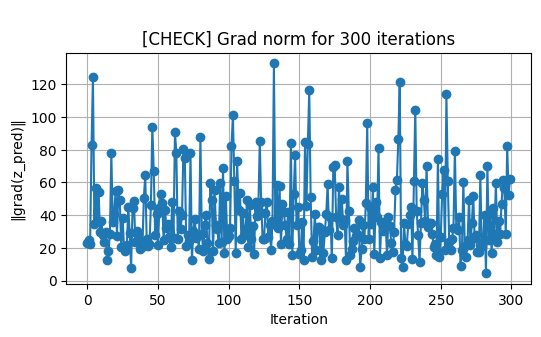

----------------------------------------------


[CHECK] Loss(z_pred=z_opt): 0.000000e+00
----------------------------------------------



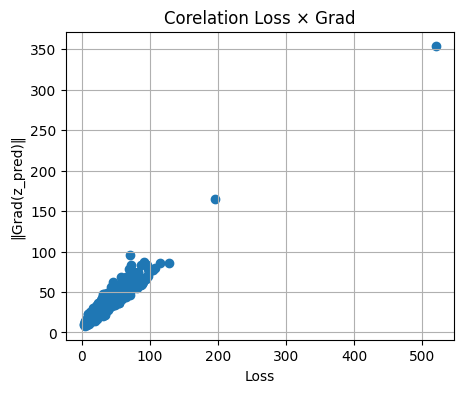

In [30]:
n_z, n_eq, n_in = 4, 2, 3
batch_size = 5

P = torch.randn(n_z, n_z)
P = 0.5 * (P + P.T)  # simetriza
q = torch.randn(n_z)
C = torch.randn(n_eq, n_z)
U = torch.randn(n_in, n_z)

loss_fn = LagrangianLoss(P, q, C, U)

z_pred = torch.randn(batch_size, n_z)
z_opt = torch.randn(batch_size, n_z)
nu_star = torch.randn(batch_size, n_eq)
lam_star = torch.randn(batch_size, n_in)

# 1 - Basic check for random values
loss = loss_fn(z_pred, z_opt, nu_star, lam_star)
print(f"[CHECK] Loss for random values: {loss.item():.6f}")
print("----------------------------------------------\n")

# 2 - Torch grad check
z_pred_small = torch.randn(1, n_z, dtype=torch.double, requires_grad=True)
z_opt_small = torch.randn(1, n_z, dtype=torch.double)
nu_small = torch.randn(1, n_eq, dtype=torch.double)
lam_small = torch.randn(1, n_in, dtype=torch.double)

def wrapped_fn(zp, zo, nu, lam):
    return loss_fn(zp, zo, nu, lam)

grad_ok = torch.autograd.gradcheck(
    wrapped_fn,
    (z_pred_small, z_opt_small, nu_small, lam_small),
    eps=1e-6, atol=1e-4, rtol=1e-3
)
print(f"\n[CHECK] Torch Gradcheck for normalized values : {grad_ok}")
print("----------------------------------------------\n")

# 3 - Grad Stats for normalized values
z_pred = torch.randn(batch_size, n_z, requires_grad=True)
loss = loss_fn(z_pred, z_opt, nu_star, lam_star)
loss.backward()

print("\n[CHECK] Grad stats:")
print(f"->  mean: {z_pred.grad.mean().item():.6f}")
print(f"->  std:  {z_pred.grad.std().item():.6f}")
print(f"->  max:  {z_pred.grad.abs().max().item():.6f}")
print("----------------------------------------------\n")

# 4 - Stability Checks
grad_norms = []
N = 300
for step in range(N):
    z_pred = torch.randn(batch_size, n_z, requires_grad=True)
    loss = loss_fn(z_pred, z_opt, nu_star, lam_star)
    loss.backward()
    grad_norms.append(z_pred.grad.norm().item())

plt.figure(figsize=(6, 3))
plt.plot(grad_norms, marker='o')
plt.title(f"\n[CHECK] Grad norm for {N} iterations")
plt.xlabel("Iteration")
plt.ylabel("‖grad(z_pred)‖")
plt.grid(True)
plt.show()
print("----------------------------------------------\n")


# 5 - Sanity Check for optimal values
loss_zero = loss_fn(z_opt, z_opt, nu_star, lam_star)
print(f"\n[CHECK] Loss(z_pred=z_opt): {loss_zero.item():.6e}")
print("----------------------------------------------\n")

# 6 - Loss output in relation to Grad Norm
grad_norms, losses = [], []
for _ in range(N):
    z_pred = torch.randn(batch_size, n_z, requires_grad=True)
    loss = loss_fn(z_pred, z_opt, nu_star, lam_star)
    loss.backward()
    grad_norms.append(z_pred.grad.norm().item())
    losses.append(loss.item())

plt.figure(figsize=(5, 4))
plt.scatter(losses, grad_norms)
plt.xlabel("Loss")
plt.ylabel("‖Grad(z_pred)‖")
plt.title("Corelation Loss × Grad")
plt.grid(True)
plt.show()


#### Loss com Lag aumentado


===== [1] CHECK loss for random values =====
Loss: 24.397181

===== [2] TORCH GRADCHECK =====
Gradcheck passed: True

===== [3] Grad stats =====
mean: 4.173017978668213
std : 8.61389446258545
max : 34.300132751464844

===== [4] Stability check (300 random preds) =====


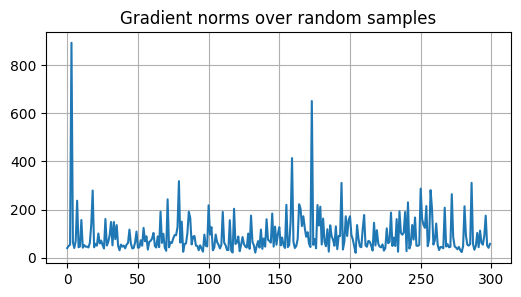


===== [5] Sanity check: z_pred = z_opt =====
Loss(z_pred=z_opt): 0.000000e+00

===== [6] Loss vs Grad norm correlation =====


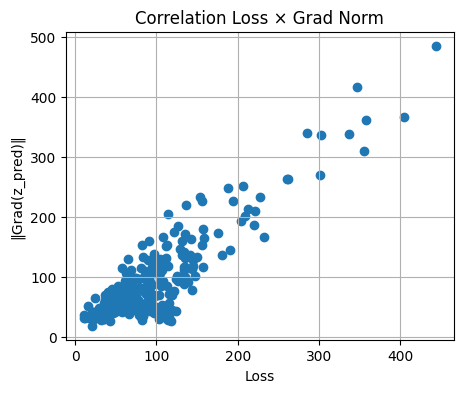

In [190]:
# ==============================================
#        Testes — Box Constrained Problem
# ==============================================
n_z  = 4    # dimensão da variável
m    = 3    # número de restrições box
batch_size = 5

# Random problem
torch.manual_seed(0)
P = torch.randn(n_z, n_z)
P = 0.5 * (P + P.T) + 1.0 * torch.eye(n_z)   # ensure PSD-ish
q = torch.randn(n_z)
D = torch.randn(m, n_z)

# random bounds
l = torch.randn(m) - 1.0
u = l + torch.rand(m) * 2.0  # u > l always

# Instantiate loss
loss_fn = AugmentedLagrangianLoss(P, q, D, rho=1.0)

# Samples
z_pred = torch.randn(batch_size, n_z, requires_grad=True)
z_opt  = torch.randn(batch_size, n_z)
lam_inf = torch.randn(batch_size, m)
lam_sup = torch.randn(batch_size, m)


print("\n===== [1] CHECK loss for random values =====")
loss = loss_fn(z_pred, z_opt, lam_inf, lam_sup, l, u)
print(f"Loss: {loss.item():.6f}")


print("\n===== [2] TORCH GRADCHECK =====")
z_pred_small = torch.randn(1, n_z, dtype=torch.double, requires_grad=True)
z_opt_small  = torch.randn(1, n_z, dtype=torch.double)
lam_inf_small = torch.randn(1, m, dtype=torch.double)
lam_sup_small = torch.randn(1, m, dtype=torch.double)
l_small = l.to(torch.double)
u_small = u.to(torch.double)

def wrapped(zp, zo, li, ls):
    return loss_fn(zp, zo, li, ls, l_small, u_small)

grad_ok = torch.autograd.gradcheck(
    wrapped,
    (z_pred_small, z_opt_small, lam_inf_small, lam_sup_small),
    eps=1e-6, atol=1e-4, rtol=1e-3
)
print("Gradcheck passed:", grad_ok)


print("\n===== [3] Grad stats =====")
z_pred = torch.randn(batch_size, n_z, requires_grad=True)
loss = loss_fn(z_pred, z_opt, lam_inf, lam_sup, l, u)
loss.backward()
print("mean:", z_pred.grad.mean().item())
print("std :", z_pred.grad.std().item())
print("max :", z_pred.grad.abs().max().item())


print("\n===== [4] Stability check (300 random preds) =====")
grad_norms = []
N = 300
for step in range(N):
    z_pred = torch.randn(batch_size, n_z, requires_grad=True)
    loss = loss_fn(z_pred, z_opt, lam_inf, lam_sup, l, u)
    loss.backward()
    grad_norms.append(z_pred.grad.norm().item())

plt.figure(figsize=(6,3))
plt.plot(grad_norms)
plt.title("Gradient norms over random samples")
plt.grid(True)
plt.show()


print("\n===== [5] Sanity check: z_pred = z_opt =====")
loss_zero = loss_fn(z_opt, z_opt, lam_inf, lam_sup, l, u)
print(f"Loss(z_pred=z_opt): {loss_zero.item():.6e}")


print("\n===== [6] Loss vs Grad norm correlation =====")
grad_norms = []
losses = []
for _ in range(N):
    z_pred = torch.randn(batch_size, n_z, requires_grad=True)
    loss = loss_fn(z_pred, z_opt, lam_inf, lam_sup, l, u)
    loss.backward()
    grad_norms.append(z_pred.grad.norm().item())
    losses.append(loss.item())

plt.figure(figsize=(5,4))
plt.scatter(losses, grad_norms)
plt.xlabel("Loss")
plt.ylabel("‖Grad(z_pred)‖")
plt.title("Correlation Loss × Grad Norm")
plt.grid(True)
plt.show()

### Avaliação com dados realistas

In [110]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

loss_fn = AugmentedLagrangianLoss(DATASET.P_scaled,
                                  DATASET.q_scaled,
                                  DATASET.D_scaled,
                                  rho=1.0).to(device)

N = 1
z_list = []
nu_list = []
lam_list = []
lb_list = []
ub_list = []

for i in range(N):
  data = DATASET.__getitem__(i)
  z_list.append(data["z"])
  nu_list.append(data["nu"])
  lam_list.append(data["lam"])
  lb_list.append(data["lb"])
  ub_list.append(data["ub"])

# 1 Tensor -> Batch (Foward takes values in [Batch_size, N])
z_batch = torch.stack(z_list).to(device)
nu_batch = torch.stack(nu_list).to(device)
lam_batch = torch.stack(lam_list).to(device)
lb_batch = torch.stack(lb_list).to(device)
ub_batch = torch.stack(ub_list).to(device)

# 1 - Sanity Check: loss for optimal value
# z_pred = z_opt = z_batch
loss = loss_fn(z_batch, z_batch, nu_batch, lam_batch, lb_batch, ub_batch)
print(f"\n[CHECK] Loss(z_pred=z_opt): {loss.item():.6e}")

z_zero = torch.zeros_like(z_batch)
loss_zero = loss_fn(z_zero, z_batch, nu_batch, lam_batch, lb_batch, ub_batch)
print(f"\n[CHECK] Loss(z_pred=0): {loss_zero.item():.6e}")

z_rand = torch.randn_like(z_batch).to(device)
loss_rand = loss_fn(z_rand, z_batch, nu_batch, lam_batch, lb_batch, ub_batch)
print(f"\n[CHECK] Loss(z_pred=random): {loss_rand.item():.6e}")



[CHECK] Loss(z_pred=z_opt): 0.000000e+00

[CHECK] Loss(z_pred=0): 1.553706e+07

[CHECK] Loss(z_pred=random): 1.357015e+08


### Simulando Convergência do treinamento

[CHECK] Loss(z_pred=z_opt): 0.000000e+00
[CHECK] Loss(z_pred=0): 6.135580e+02
[CHECK] Loss(z_pred=random): 3.342109e+03


Step 00 | α=0.00 | Loss = 6.135580e+02




Step 01 | α=0.05 | Loss = 5.926196e+02




Step 02 | α=0.10 | Loss = 5.679625e+02




Step 03 | α=0.15 | Loss = 5.398491e+02




Step 04 | α=0.20 | Loss = 5.085860e+02




Step 05 | α=0.25 | Loss = 4.745233e+02




Step 06 | α=0.30 | Loss = 4.380552e+02




Step 07 | α=0.35 | Loss = 3.996196e+02




Step 08 | α=0.40 | Loss = 3.596984e+02




Step 09 | α=0.45 | Loss = 3.188171e+02




Step 10 | α=0.50 | Loss = 2.775453e+02




Step 11 | α=0.55 | Loss = 2.364964e+02




Step 12 | α=0.60 | Loss = 1.963276e+02




Step 13 | α=0.65 | Loss = 1.577400e+02




Step 14 | α=0.70 | Loss = 1.214785e+02




Step 15 | α=0.75 | Loss = 8.833188e+01




Step 16 | α=0.80 | Loss = 5.913285e+01




Step 17 | α=0.85 | Loss = 3.475787e+01




Step 18 | α=0.90 | Loss = 1.612730e+01




Step 19 | α=0.95 | Loss = 4.205313e+00




Step 20 | α=1.00 |

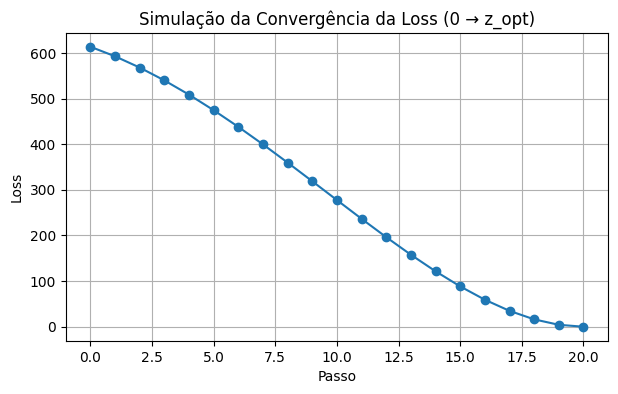

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instância da loss
loss_fn = LagrangianLoss(
    DATASET.P_scaled,
    DATASET.q_scaled,
    DATASET.C_scaled,
    DATASET.U_scaled,
).to(device)

# Pegamos 1 única amostra
data = DATASET.__getitem__(0)

z_opt = data["z"].unsqueeze(0).to(device)   # shape (1, dim_z)
nu     = data["nu"].unsqueeze(0).to(device)
lam    = data["lam"].unsqueeze(0).to(device)

# 1 - Sanity Check
loss_opt = loss_fn(z_opt, z_opt, nu, lam).item()
print(f"[CHECK] Loss(z_pred=z_opt): {loss_opt:.6e}")

z_zero = torch.zeros_like(z_opt)
loss_zero = loss_fn(z_zero, z_opt, nu, lam).item()
print(f"[CHECK] Loss(z_pred=0): {loss_zero:.6e}")

z_rand = torch.randn_like(z_opt)
loss_rand = loss_fn(z_rand, z_opt, nu, lam).item()
print(f"[CHECK] Loss(z_pred=random): {loss_rand:.6e}")

# ============================================================
# 2 - Simulação: z_pred evolui de 0 → z_opt em 20 passos
# ============================================================
num_steps = 20
loss_values = []

for t in range(num_steps + 1):

    alpha = t / num_steps  # varia de 0 → 1
    z_pred = (alpha * z_opt).clone()

    loss_t = loss_fn(z_pred, z_opt, nu, lam).item()
    loss_values.append(loss_t)

    print(f"\n\nStep {t:02d} | α={alpha:.2f} | Loss = {loss_t:.6e}\n\n")


# ============================================================
# 3 - Plot (opcional)
# ============================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(loss_values, marker='o')
plt.title("Simulação da Convergência da Loss (0 → z_opt)")
plt.xlabel("Passo")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# 3. Definição da Rede

In [33]:
class PlannerNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden=(32, 32)):

      super().__init__()
      layers = []
      prev =  input_dim

      for h in hidden: # Hidden Layers Creatio
        layers += [nn.Linear(prev, h), nn.ReLU(inplace=True)]
        prev = h

      out = nn.Linear(prev, output_dim) # Output Layer

      nn.init.xavier_uniform_(out.weight, gain=0.5); nn.init.zeros_(out.bias)
      self.net = nn.Sequential(*layers, out)

      for m in self.net: # init internal layers
        if isinstance(m, nn.Linear) and m is not out:
          nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x_std):  # Receives x_std and return z_scaled
        return self.net(x_std)

In [34]:
MODEL = PlannerNet(input_dim=MPC.n_states,
                   output_dim=MPC.dim_z,
                   hidden=(64, 64)).float()

# 4. Treinamento

## 4.1 Validação do Treino

In [38]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Memorização -> Converge para 1 instância


=== Iniciando teste de OVERFIT em 1 exemplo ===

[Epoch    0] Loss = 6.108261e+02 | ||z_pred - z_opt|| = 8.575939e+00
[Epoch  200] Loss = 2.009975e+00 | ||z_pred - z_opt|| = 1.114863e+01
[Epoch  400] Loss = 1.760782e-09 | ||z_pred - z_opt|| = 1.133828e+01
[Epoch  600] Loss = 0.000000e+00 | ||z_pred - z_opt|| = 1.133827e+01
[Epoch  800] Loss = 0.000000e+00 | ||z_pred - z_opt|| = 1.133827e+01
[Epoch 1000] Loss = 0.000000e+00 | ||z_pred - z_opt|| = 1.133827e+01
[Epoch 1200] Loss = 0.000000e+00 | ||z_pred - z_opt|| = 1.133827e+01
[Epoch 1400] Loss = 0.000000e+00 | ||z_pred - z_opt|| = 1.133827e+01
[Epoch 1499] Loss = 0.000000e+00 | ||z_pred - z_opt|| = 1.133827e+01

Treino concluído!



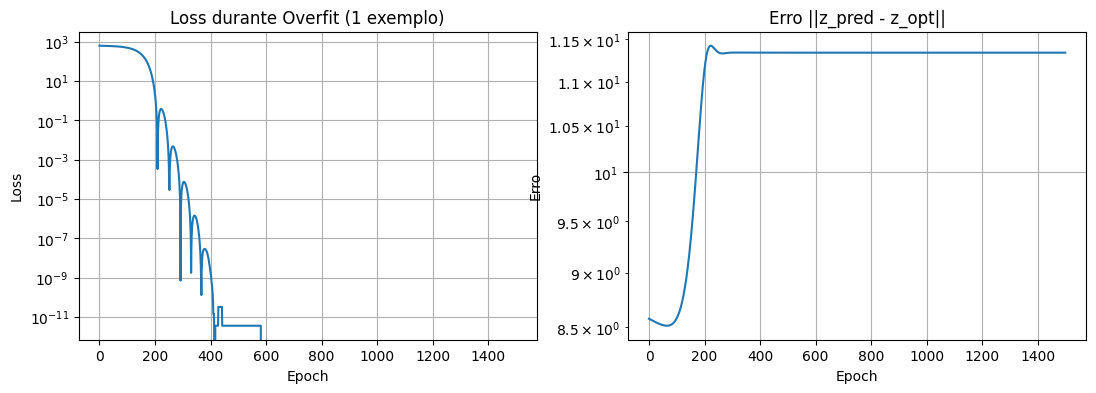

In [39]:
DATASET = MPC_DATASET(MPC)
MODEL = PlannerNet(
    input_dim=MPC.n_states,
    output_dim=MPC.dim_z,
    hidden=(64, 64)
).to(device).float()

LOSS = LagrangianLoss(
    DATASET.P_scaled,
    DATASET.q_scaled,
    DATASET.C_scaled,
    DATASET.U_scaled,
).to(device).float()

sample = DATASET[0]
x      = sample["x"].unsqueeze(0).to(device)
z_opt  = sample["z"].unsqueeze(0).to(device)
nu     = sample["nu"].unsqueeze(0).to(device)
lam    = sample["lam"].unsqueeze(0).to(device)

optimizer = torch.optim.Adam(MODEL.parameters(), lr=1e-4)

# TRAINING

epochs = 1500

loss_history = []
err_history = []
pred_history = []

print("\n=== Iniciando teste de OVERFIT em 1 exemplo ===\n")

for epoch in range(epochs):

    # Forward
    z_pred = MODEL(x)
    loss = LOSS(z_pred, z_opt, nu, lam)

    # Métricas
    with torch.no_grad():
        err = (z_pred - z_opt).norm().item()
        loss_history.append(loss.item())
        err_history.append(err)
        pred_history.append(z_pred.detach().cpu().numpy())

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logs ocasionais
    if epoch % 200 == 0 or epoch == epochs - 1:
        print(f"[Epoch {epoch:4d}] Loss = {loss.item():.6e} | ||z_pred - z_opt|| = {err:.6e}")

print("\nTreino concluído!\n")

# ================================================================
# 3. Gráficos do resultado
# ================================================================

plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.plot(loss_history)
plt.yscale("log")
plt.title("Loss durante Overfit (1 exemplo)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(err_history)
plt.yscale("log")
plt.title("Erro ||z_pred - z_opt||")
plt.xlabel("Epoch")
plt.ylabel("Erro")
plt.grid(True)

plt.show()


#### CONCLUSÃO:

A loss está caindo, mas depois ele converge para outro ponto parece, como se encontra-se outro ótimo. Será que isso é normal?



### Visualização do Gradiente ao longo do treino

[Epoch 1] Loss = 17780539.082760
[Epoch 2] Loss = 17759697.027891
[Epoch 3] Loss = 17740710.466736
[Epoch 4] Loss = 17718272.227081
[Epoch 5] Loss = 17700973.298919
[Epoch 6] Loss = 17678641.970936
[Epoch 7] Loss = 17658980.480765
[Epoch 8] Loss = 17637597.081051
[Epoch 9] Loss = 17615936.531700
[Epoch 10] Loss = 17593968.469397
[Epoch 11] Loss = 17573021.824858
[Epoch 12] Loss = 17552222.228581
[Epoch 13] Loss = 17529895.995624
[Epoch 14] Loss = 17508015.404476
[Epoch 15] Loss = 17486055.285418
[Epoch 16] Loss = 17468221.711659
[Epoch 17] Loss = 17445778.711069
[Epoch 18] Loss = 17425733.761826
[Epoch 19] Loss = 17406253.630307
[Epoch 20] Loss = 17383497.214283


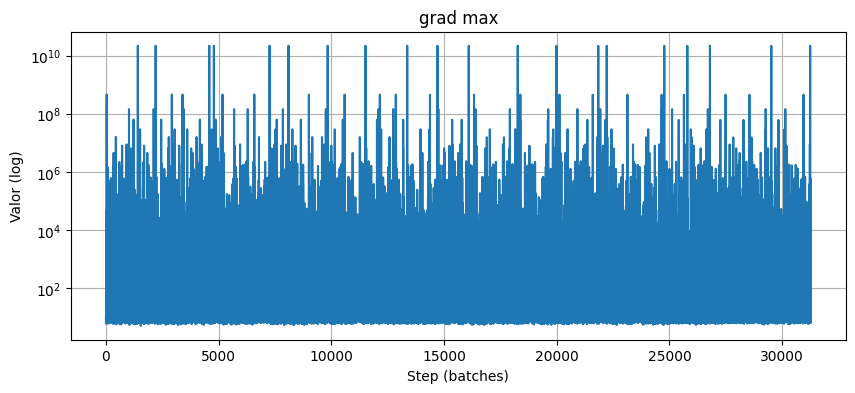

/var/folders/67/mq64v1c14278mbk47gs2dvz40000gn/T/ipykernel_24391/3316816558.py:95: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


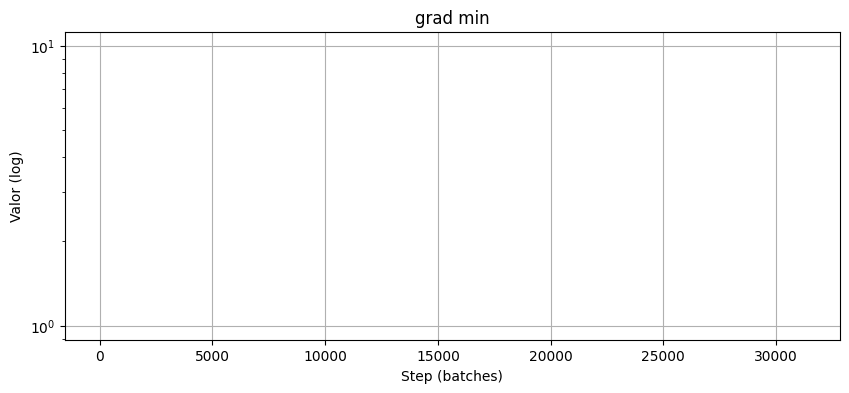

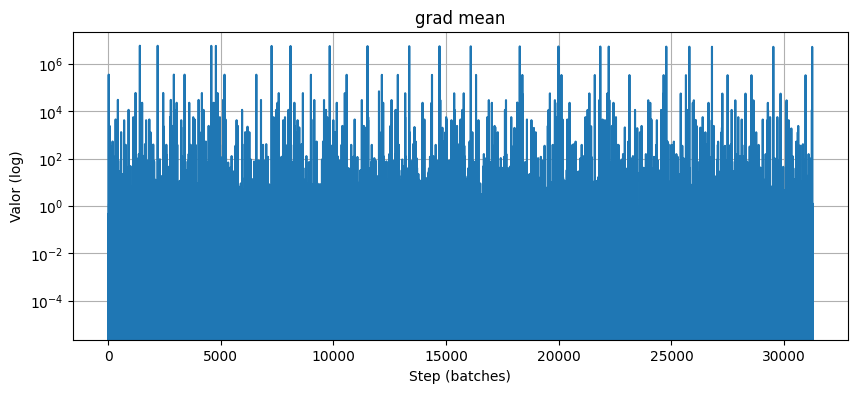

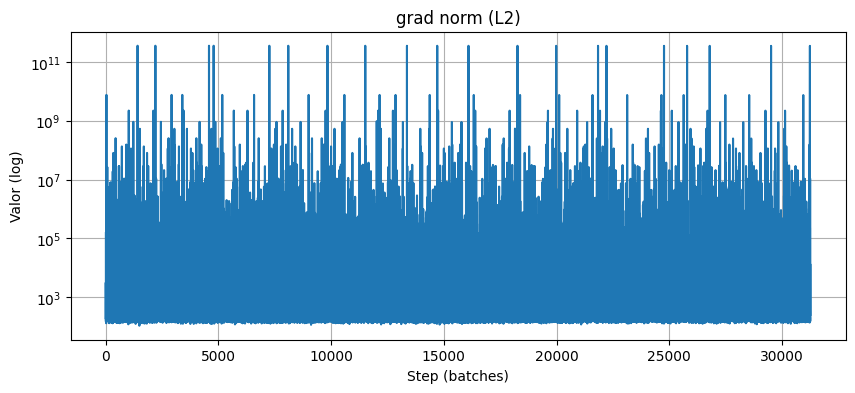

In [36]:
grad_max_list = []
grad_min_list = []
grad_mean_list = []
grad_norm_list = []

def record_gradients(model):
    grads = []
    for param in model.parameters():
        if param.grad is not None:
            grads.append(param.grad.view(-1))

    if len(grads) == 0:
        grad_max_list.append(0)
        grad_min_list.append(0)
        grad_mean_list.append(0)
        grad_norm_list.append(0)
        return

    g = torch.cat(grads)
    grad_max_list.append(g.max().item())
    grad_min_list.append(g.min().item())
    grad_mean_list.append(g.mean().item())
    grad_norm_list.append(torch.norm(g).item())


# =============================================================
# TREINAMENTO COM MONITORAMENTO DOS GRADIENTES
# =============================================================

device = torch.device("mps" if torch.mps.is_available() else "cpu")

DATASET = MPC_DATASET(MPC)
MODEL = PlannerNet(
    input_dim=MPC.n_states,
    output_dim=MPC.dim_z,
    hidden=(64, 64)
).to(device).float()

LOSS = LagrangianLoss(
    DATASET.P_scaled,
    DATASET.q_scaled,
    DATASET.C_scaled,
    DATASET.U_scaled,
).to(device).float()

loader = DataLoader(DATASET, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(MODEL.parameters(), lr=1e-7)

num_epochs = 20
loss_history = []

for epoch in range(num_epochs):

    epoch_loss = 0.0

    for batch in loader:
        x     = batch["x"].to(device)
        z_opt = batch["z"].to(device)
        nu    = batch["nu"].to(device)
        lam   = batch["lam"].to(device)

        # forward
        z_pred = MODEL(x)
        loss = LOSS(z_pred, z_opt, nu, lam)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # registra gradientes
        record_gradients(MODEL)

        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(loader))
    print(f"[Epoch {epoch+1}] Loss = {loss_history[-1]:.6f}")


# =============================================================
# PLOT
# =============================================================
plt.figure(figsize=(10,4))
plt.plot(grad_max_list)
plt.yscale("log")
plt.title("grad max")
plt.xlabel("Step (batches)")
plt.ylabel("Valor (log)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(grad_min_list)
plt.yscale("log")
plt.title("grad min")
plt.xlabel("Step (batches)")
plt.ylabel("Valor (log)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(grad_mean_list)
plt.yscale("log")
plt.title("grad mean")
plt.xlabel("Step (batches)")
plt.ylabel("Valor (log)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(grad_norm_list)
plt.yscale("log")
plt.title("grad norm (L2)")
plt.xlabel("Step (batches)")
plt.ylabel("Valor (log)")
plt.grid(True)
plt.show()

### Investigação do Gradiente

[Epoch 1] Loss = 68516333.065913
[Epoch 2] Loss = 12089480.292780
[Epoch 3] Loss = 1905734.384778
[Epoch 4] Loss = 1366315.271485
[Epoch 5] Loss = 6190042.208224
[Epoch 6] Loss = 8616221.425898
[Epoch 7] Loss = 2908928.928702
[Epoch 8] Loss = 6059950.322079
[Epoch 9] Loss = 3154075.076072
[Epoch 10] Loss = 6160371.347907


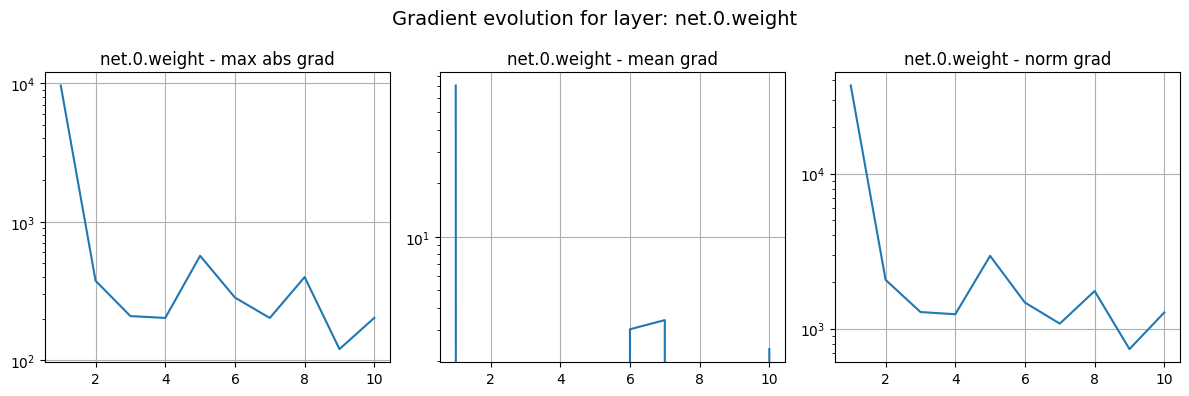

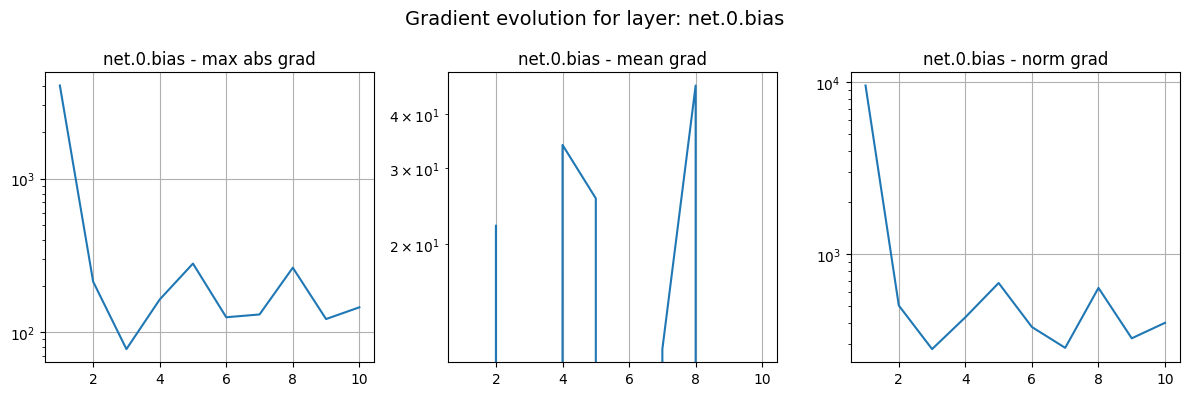

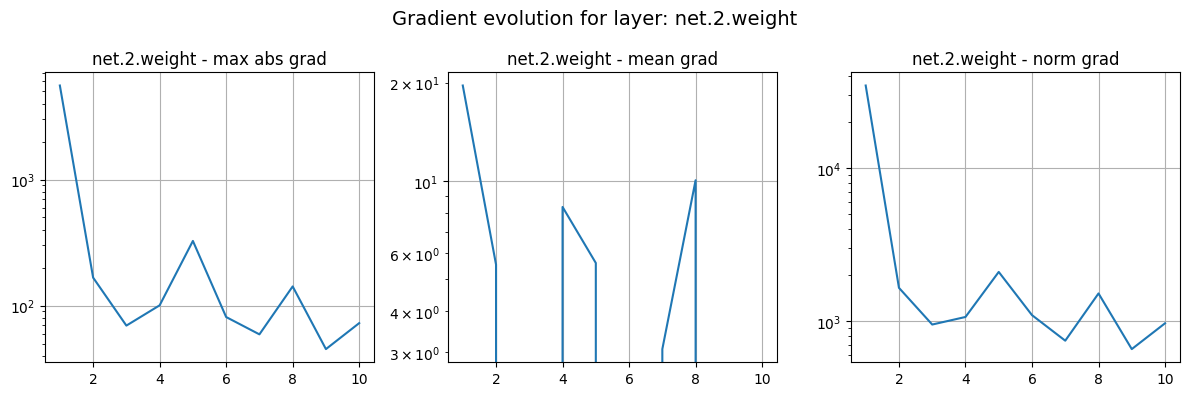

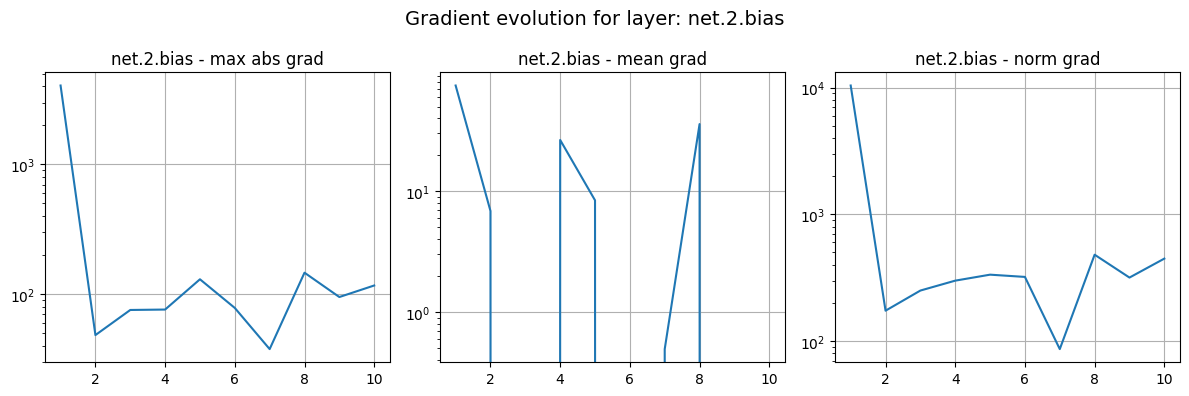

/var/folders/67/mq64v1c14278mbk47gs2dvz40000gn/T/ipykernel_24391/3107252616.py:84: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


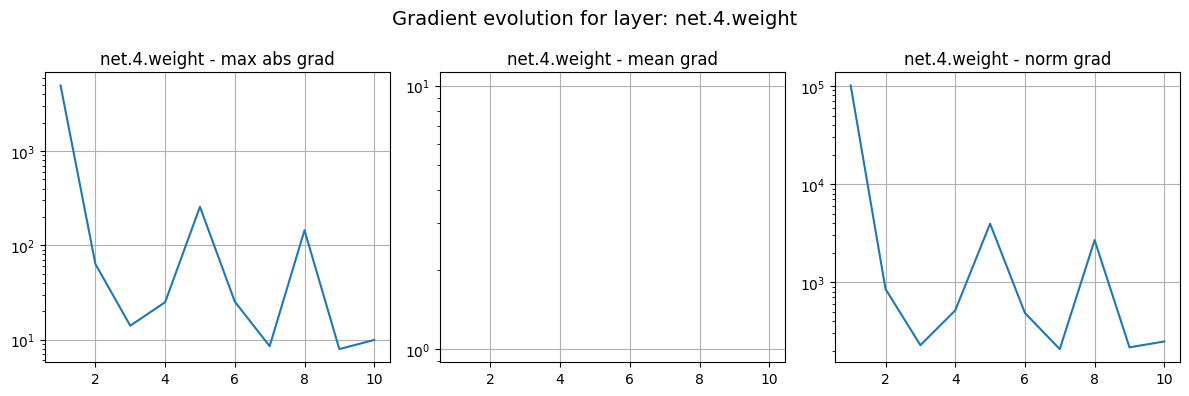

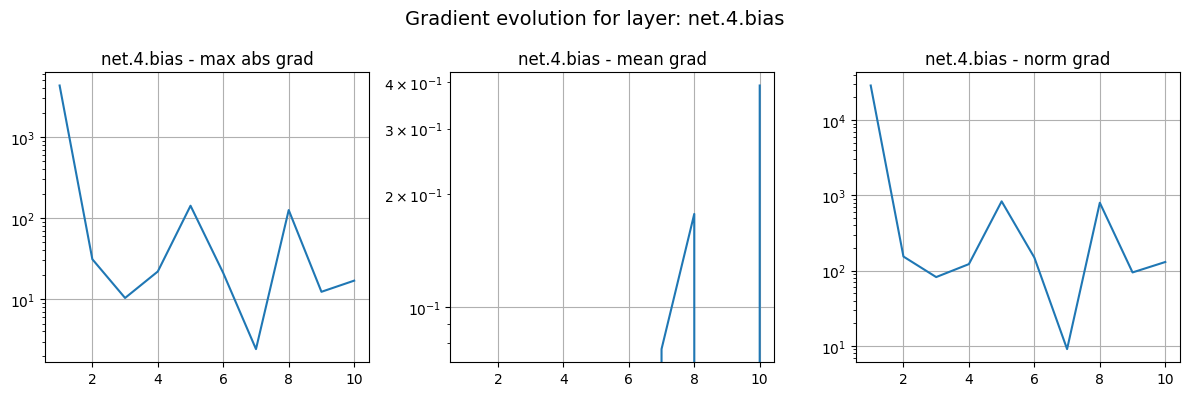

In [40]:
def compute_grad_stats(model):
    stats = {}
    for name, param in model.named_parameters():
        if param.grad is None:
            stats[name] = {
                "max_abs": 0.0,
                "mean": 0.0,
                "norm": 0.0
            }
            continue

        g = param.grad.detach().view(-1)
        stats[name] = {
            "max_abs": g.abs().max().item(),
            "mean": g.mean().item(),
            "norm": g.norm(2).item()
        }
    return stats

grad_history = {}   # dict: layer_name → {max_abs:[], mean:[], norm:[]}

def init_grad_history(model):
    for name, _ in model.named_parameters():
        grad_history[name] = {
            "max_abs": [],
            "mean": [],
            "norm": []
        }

init_grad_history(MODEL)


num_epochs = 10
loss_history = []

for epoch in range(num_epochs):

    epoch_loss = 0.0

    for batch in loader:
        x     = batch["x"].to(device)
        z_opt = batch["z"].to(device)
        nu    = batch["nu"].to(device)
        lam   = batch["lam"].to(device)

        optimizer.zero_grad()

        z_pred = MODEL(x)
        loss = LOSS(z_pred, z_opt, nu, lam)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    stats = compute_grad_stats(MODEL)
    for name in stats:
        grad_history[name]["max_abs"].append(stats[name]["max_abs"])
        grad_history[name]["mean"].append(stats[name]["mean"])
        grad_history[name]["norm"].append(stats[name]["norm"])

    loss_history.append(epoch_loss / len(loader))
    print(f"[Epoch {epoch+1}] Loss = {loss_history[-1]:.6f}")


# =============================================================
# PLOTS DOS GRADIENTES PARA CADA CAMADA
# =============================================================
epochs_axis = range(1, num_epochs + 1)

for name in grad_history:
    plt.figure(figsize=(12,4))

    # max abs
    plt.subplot(1,3,1)
    plt.plot(epochs_axis, grad_history[name]["max_abs"])
    plt.yscale("log")
    plt.title(f"{name} - max abs grad")
    plt.grid(True)

    # mean
    plt.subplot(1,3,2)
    plt.plot(epochs_axis, grad_history[name]["mean"])
    plt.yscale("log")
    plt.title(f"{name} - mean grad")
    plt.grid(True)

    # norm
    plt.subplot(1,3,3)
    plt.plot(epochs_axis, grad_history[name]["norm"])
    plt.yscale("log")
    plt.title(f"{name} - norm grad")
    plt.grid(True)

    plt.suptitle(f"Gradient evolution for layer: {name}", fontsize=14)
    plt.tight_layout()
    plt.show()


#### Conclusão:
Explosões acontecem em épocas específicas em todas as camadas

### Analisar Cálculo da Loss nos momentos de Explosão de Gradiente


==== Iniciando treinamento com monitoramento de explosões ====


🔥 EXPLOSÃO DETECTADA! epoch 0 batch 20 layer net.0.weight
grad stats: {'max': 8397.7041015625, 'mean': 27.7977294921875, 'norm': 31167.05859375}
loss: 161582.921875
z_pred max abs: 0.4186863899230957 


🔥 EXPLOSÃO DETECTADA! epoch 0 batch 20 layer net.0.bias
grad stats: {'max': 1692.8447265625, 'mean': 53.635433197021484, 'norm': 5157.34423828125}
loss: 161582.921875
z_pred max abs: 0.4186863899230957 


🔥 EXPLOSÃO DETECTADA! epoch 0 batch 20 layer net.2.weight
grad stats: {'max': 6381.125, 'mean': 66.49494934082031, 'norm': 50076.56640625}
loss: 161582.921875
z_pred max abs: 0.4186863899230957 


🔥 EXPLOSÃO DETECTADA! epoch 0 batch 20 layer net.2.bias
grad stats: {'max': 2862.84228515625, 'mean': 130.34152221679688, 'norm': 8108.06884765625}
loss: 161582.921875
z_pred max abs: 0.4186863899230957 


🔥 EXPLOSÃO DETECTADA! epoch 0 batch 20 layer net.4.weight
grad stats: {'max': 9635.4775390625, 'mean': 4.722743511199951, '

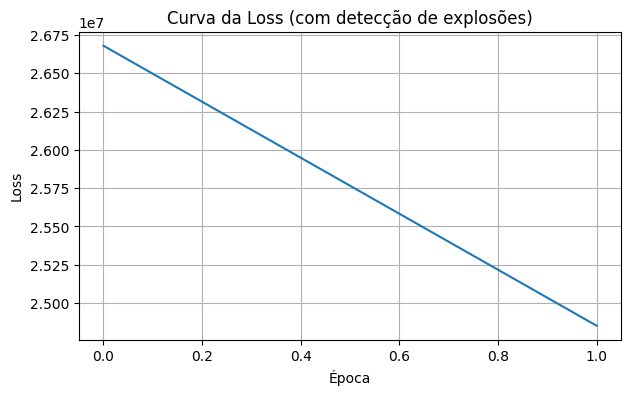

2216 explosões encontradas — gerando gráficos...


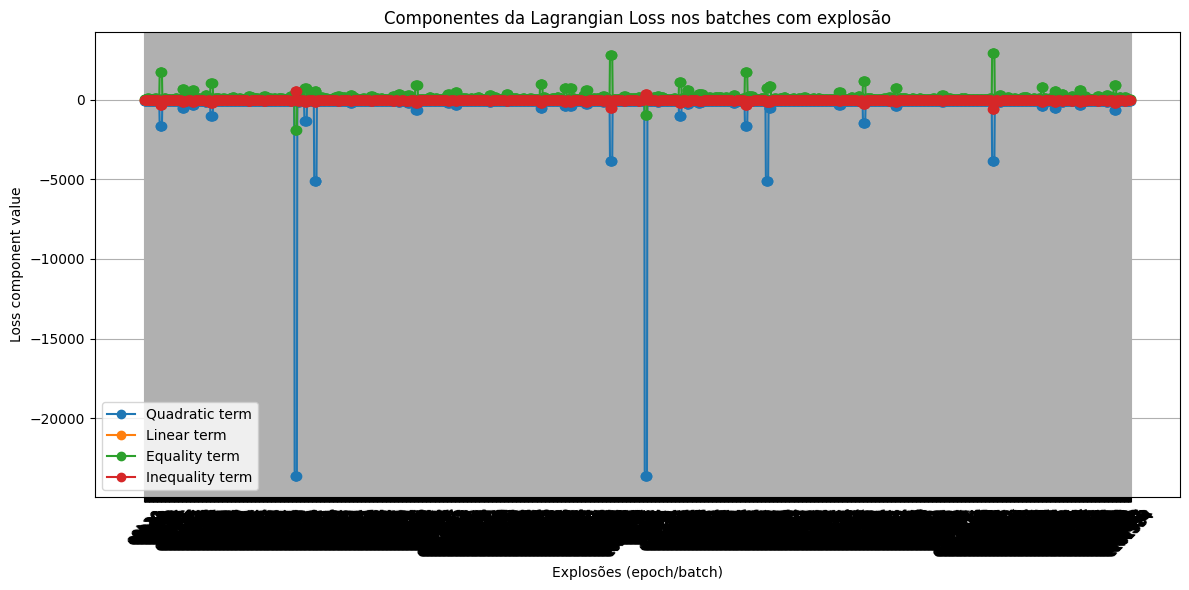


=== Ranking de intensidade dos termos durante explosões ===
Média |quad| : 2.721e+02
Média |lin|  : 0.000e+00
Média |eq|   : 1.785e+02
Média |ineq| : 3.371e+01

Maior valor observado por componente:
  quad : 2.364e+04
  lin  : 0.000e+00
  eq   : 2.920e+03
  ineq : 5.424e+02


In [41]:
THRESH = 1e3
MAX_EPOCHS = 2

explosion_log = []

def get_grad_stats_per_layer(model):
    """
    Retorna um dicionário:
    {
        "layer_name": { "max": ..., "mean": ..., "norm": ... },
        ...
    }
    """
    stats = {}
    for name, param in model.named_parameters():
        if param.grad is None:
            continue

        g = param.grad.view(-1)
        stats[name] = {
            "max":  g.abs().max().item(),
            "mean": g.mean().item(),
            "norm": torch.norm(g).item(),
        }
    return stats


def compute_loss_components(loss_fn, z_pred, z_opt, nu, lam):
    """Executa forward separado para obter termos individuais."""
    quad, lin, eq, ineq = loss_fn.forward_components(z_pred, z_opt, nu, lam)
    return {
        "quad": quad.item(),
        "lin": lin.item(),
        "eq": eq.item(),
        "ineq": ineq.item(),
    }


# =====================================================================
# INICIALIZAÇÃO DO MODELO E DATASET
# =====================================================================

DATASET = MPC_DATASET(MPC)
loader = DataLoader(DATASET, batch_size=64, shuffle=True)

MODEL = PlannerNet(
    input_dim=MPC.n_states,
    output_dim=MPC.dim_z,
    hidden=(64, 64)
).to(device)

LOSS = LagrangianLoss(
    DATASET.P_scaled,
    DATASET.q_scaled,
    DATASET.C_scaled,
    DATASET.U_scaled,
).to(device)

optimizer = torch.optim.Adam(MODEL.parameters(), lr=1e-5)

loss_history = []

print("\n==== Iniciando treinamento com monitoramento de explosões ====\n")


# =====================================================================
# LOOP DE TREINAMENTO
# =====================================================================

for epoch in range(MAX_EPOCHS):

    epoch_loss = 0.0

    for batch_idx, batch in enumerate(loader):

        x     = batch["x"].to(device)
        z_opt = batch["z"].to(device)
        nu    = batch["nu"].to(device)
        lam   = batch["lam"].to(device)

        # ---------------------------------------------------------
        # Forward
        # ---------------------------------------------------------
        z_pred = MODEL(x)
        loss = LOSS(z_pred, z_opt, nu, lam)

        # ---------------------------------------------------------
        # Backward
        # ---------------------------------------------------------
        optimizer.zero_grad()
        loss.backward()

        # ---------------------------------------------------------
        # Checar explosões de gradiente por layer
        # ---------------------------------------------------------
        grad_stats = get_grad_stats_per_layer(MODEL)

        for layer_name, gstats in grad_stats.items():
            if gstats["max"] > THRESH:  # explosão detectada
                explosion_log.append({
                    "epoch": epoch,
                    "batch": batch_idx,
                    "layer": layer_name,
                    "grad_stats": gstats,
                    "loss_total": loss.item(),
                    "loss_components": compute_loss_components(LOSS, z_pred, z_opt, nu, lam),
                    "z_pred_mean": z_pred.mean().item(),
                    "z_pred_max": z_pred.abs().max().item(),
                })
                print(f"\n🔥 EXPLOSÃO DETECTADA! epoch {epoch} batch {batch_idx} layer {layer_name}")
                print("grad stats:", gstats)
                print("loss:", loss.item())
                print("z_pred max abs:", z_pred.abs().max().item(), "\n")

        # ---------------------------------------------------------
        # Optimizer step
        # ---------------------------------------------------------
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(loader))
    print(f"[Epoch {epoch+1}] Loss = {loss_history[-1]:.6f}")

print("\n==== Treinamento concluído! ====\n")
print(f"Explosões registradas: {len(explosion_log)}")


# =====================================================================
# GRÁFICO DA LOSS
# =====================================================================

plt.figure(figsize=(7,4))
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva da Loss (com detecção de explosões)")
plt.grid(True)
plt.show()


# =====================================================================
# VISUALIZAÇÃO DAS COMPONENTES DA LOSS NOS BATCHES COM EXPLOSÃO
# =====================================================================

if len(explosion_log) == 0:
    print("Nenhuma explosão registrada — nada para plotar.")
else:
    print(f"{len(explosion_log)} explosões encontradas — gerando gráficos...")

    import numpy as np

    # Extrair séries por componente
    quad_vals = []
    lin_vals  = []
    eq_vals   = []
    ineq_vals = []
    labels    = []

    for e in explosion_log:
        lc = e["loss_components"]
        quad_vals.append(lc["quad"])
        lin_vals.append(lc["lin"])
        eq_vals.append(lc["eq"])
        ineq_vals.append(lc["ineq"])
        labels.append(f"e{e['epoch']}b{e['batch']}")

    quad_vals = np.array(quad_vals)
    lin_vals  = np.array(lin_vals)
    eq_vals   = np.array(eq_vals)
    ineq_vals = np.array(ineq_vals)

    # -----------------------------------------------------------------
    # GRÁFICO
    # -----------------------------------------------------------------

    plt.figure(figsize=(12, 6))
    plt.plot(quad_vals, label="Quadratic term", marker="o")
    plt.plot(lin_vals,  label="Linear term",    marker="o")
    plt.plot(eq_vals,   label="Equality term",  marker="o")
    plt.plot(ineq_vals, label="Inequality term",marker="o")

    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.ylabel("Loss component value")
    plt.xlabel("Explosões (epoch/batch)")
    plt.title("Componentes da Lagrangian Loss nos batches com explosão")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # RANKING NUMÉRICO
    # -----------------------------------------------------------------

    print("\n=== Ranking de intensidade dos termos durante explosões ===")
    print(f"Média |quad| : {np.abs(quad_vals).mean():.3e}")
    print(f"Média |lin|  : {np.abs(lin_vals).mean():.3e}")
    print(f"Média |eq|   : {np.abs(eq_vals).mean():.3e}")
    print(f"Média |ineq| : {np.abs(ineq_vals).mean():.3e}")

    biggest = {
        "quad": np.abs(quad_vals).max(),
        "lin" : np.abs(lin_vals).max(),
        "eq"  : np.abs(eq_vals).max(),
        "ineq": np.abs(ineq_vals).max(),
    }
    print("\nMaior valor observado por componente:")
    for k, v in biggest.items():
        print(f"  {k:5s}: {v:.3e}")


### Visualização dos pesos ao longo do treino para verificar aprendizado


==== Treinamento para análise de convergência de pesos ====

[Epoch 1] Loss = 17985439.280898
[Epoch 2] Loss = 15412463.763884
[Epoch 3] Loss = 12858758.483363
[Epoch 4] Loss = 10574518.348112
[Epoch 5] Loss = 8341919.266065
[Epoch 6] Loss = 6459195.342796
[Epoch 7] Loss = 4748920.086566
[Epoch 8] Loss = 3376367.825988
[Epoch 9] Loss = 2197184.141013
[Epoch 10] Loss = 1335675.069077
[Epoch 11] Loss = 649329.938983
[Epoch 12] Loss = 326410.337423
[Epoch 13] Loss = 215912.896516
[Epoch 14] Loss = 186535.028621
[Epoch 15] Loss = 178425.412694
[Epoch 16] Loss = 204831.265440
[Epoch 17] Loss = 186281.164896
[Epoch 18] Loss = 143032.336506
[Epoch 19] Loss = 188577.620462
[Epoch 20] Loss = 138675.273990
[Epoch 21] Loss = 155345.441256
[Epoch 22] Loss = 138572.124633
[Epoch 23] Loss = 157692.718113
[Epoch 24] Loss = 134326.592671
[Epoch 25] Loss = 117261.617022
[Epoch 26] Loss = 139943.825864
[Epoch 27] Loss = 151414.136274
[Epoch 28] Loss = 110859.082555
[Epoch 29] Loss = 129536.690918
[Epoc

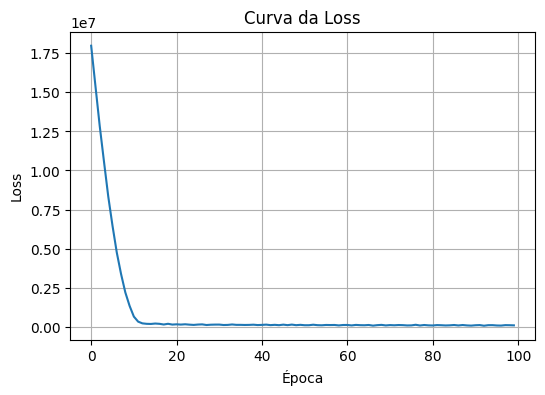

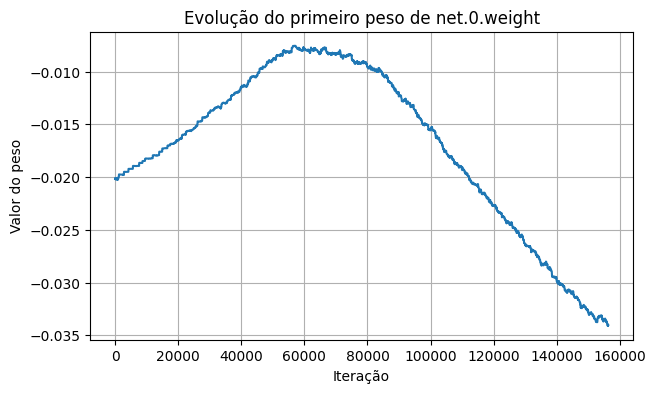

In [42]:
# =====================================================================
# CONFIGURAÇÕES
# =====================================================================

MAX_EPOCHS = 100
LR = 1e-5

weight_trace = {}  # dict[layer_name] = list of tensors ao longo do treino

def record_weights(model, weight_trace):
    """Salva uma cópia dos pesos e vieses do modelo em cada iteração."""
    for name, param in model.named_parameters():
        if name not in weight_trace:
            weight_trace[name] = []
        weight_trace[name].append(param.detach().cpu().clone())


# =====================================================================
# INICIALIZAÇÃO DO MODELO, DATASET E OTIMIZADOR
# =====================================================================

DATASET = MPC_DATASET(MPC)
loader  = DataLoader(DATASET, batch_size=64, shuffle=True)

MODEL = PlannerNet(
    input_dim=MPC.n_states,
    output_dim=MPC.dim_z,
    hidden=(64, 64)
).to(device)

LOSS = LagrangianLoss(
    DATASET.P_scaled,
    DATASET.q_scaled,
    DATASET.C_scaled,
    DATASET.U_scaled,
).to(device)

optimizer = torch.optim.Adam(MODEL.parameters(), lr=LR)

loss_history = []

print("\n==== Treinamento para análise de convergência de pesos ====\n")


# =====================================================================
# LOOP DE TREINAMENTO
# =====================================================================

for epoch in range(MAX_EPOCHS):

    epoch_loss = 0.0

    for batch_idx, batch in enumerate(loader):

        x     = batch["x"].to(device)
        z_opt = batch["z"].to(device)
        nu    = batch["nu"].to(device)
        lam   = batch["lam"].to(device)

        # Forward
        z_pred = MODEL(x)
        loss   = LOSS(z_pred, z_opt, nu, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Registrar pesos após o update
        record_weights(MODEL, weight_trace)

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(loader))
    print(f"[Epoch {epoch+1}] Loss = {loss_history[-1]:.6f}")

print("\n==== Treinamento concluído! ====")
print(f"Foram registradas {sum(len(v) for v in weight_trace.values())} snapshots de parâmetros.")


# =====================================================================
# PLOT DA LOSS
# =====================================================================

plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva da Loss")
plt.grid(True)
plt.show()


# =====================================================================
# EXEMPLO DE VISUALIZAÇÃO DE CONVERGÊNCIA DE UM PESO
# =====================================================================

# Escolha automática de um peso para ilustrar
example_layer = list(weight_trace.keys())[0]          # primeira camada
example_param = weight_trace[example_layer]           # lista de tensores

# Converter para uma série temporal do primeiro peso do tensor
series = [w.view(-1)[0].item() for w in example_param]

plt.figure(figsize=(7,4))
plt.plot(series)
plt.title(f"Evolução do primeiro peso de {example_layer}")
plt.xlabel("Iteração")
plt.ylabel("Valor do peso")
plt.grid(True)
plt.show()
